In [1]:
# Nonlinear MPC test using kinematic bicycle model for car
# We want to use the kinematic bicycle model from this paper (Figure 3)
# https://link-springer-com.stanford.idm.oclc.org/article/10.1007/s13177-020-00226-1#Tab4

# which has states:
# x, y = positional coordinates in inertial frame
# ψ = angle of car centerline in inertial frame
# ̇ψ = change of angle
# β = angle between car centerline and velocity vector
# ̇β = change of angle

# and has the equations:
# ̇x = v cos(ψ + β)
# ̇y = v sin(ψ + β)
# ̇v = a
# ̇ψ = v / lᵣ sin(β)
# β = arctan(lᵣ/(lf + lᵣ) tan(δf))
# ̇β = v/(lf + lᵣ) tan(δf) - v/lᵣ sin(β)
# ̇δf = ω

# and we want to solve it. Define the model:


The model has state and input:
\begin{gather*}
z = \begin{bmatrix}x\\ y\\ v\\ \psi\end{bmatrix},\quad
u = \begin{bmatrix}a\\ \delta_f\end{bmatrix},\quad
\end{gather*}
where the two control signals are $a$, the acceleration command, and $\delta_f$, the front steering angle (in radians).
The nonlinear model is:
\begin{gather*}
\begin{bmatrix}
\dot x\\ \dot y\\ \dot v\\ \dot\psi
%\\ \dot\beta
\end{bmatrix} =
\begin{bmatrix}
v\cos(\psi + \beta)
\\
v\sin(\psi + \beta)
\\
a
\\
\frac{v}{l_r}\sin(\beta)
%\\
%\frac{v}{l_f + l_r}\tan(\delta_f) - \frac{v}{l_r}\sin(\beta)
\end{bmatrix}
\end{gather*}

## Casadi setup
From http://casadi.sourceforge.net/v3.4.4/users_guide/casadi-users_guide.pdf

In [2]:
# Library dependencies
import casadi
import numpy             as np
import matplotlib.pyplot as plt
import matplotlib        as mpl
import bezier

# Local dependencies
from direct_collocation  import MpcProblem
from KinematicBicycleCar import KinematicBicycleCar
from roadrunner_2          import Roadrunner, Segment
from road                import iso_double_lane_change as test_road

## Initial state and cost

In [3]:
# Initialize the car model with 0.05 second steps and 30 step lookahead
car = KinematicBicycleCar(N=30, step=0.075)

DESIRED_SPEED = 5.0

# Cost - we want the velocity to stay around 5 m/s, so we penalize deviations from that.
cost = (car.dae.x[0][2]-DESIRED_SPEED)**2

In [4]:
n_test_road_pts,_ = np.shape(test_road)

roadrunner = Roadrunner(road_center = test_road,                    # Road centerline points
                        road_width  = np.ones(n_test_road_pts)*5.0, # constant lane width of 5 meters
                        P           = 10) # Number of points to try curve-fitting at a time



In [5]:
# Boundary functions

# terrible hack, need to fix right away

global dist_already_traveled
dist_already_traveled = 0.0

def road_center(model:KinematicBicycleCar, k:int)->np.array:
    global dist_already_traveled

    (xy, angle, _) = roadrunner.evaluate(model.step*np.sum(model.state_estimate[2,:k]), full_data=True)

    center = np.empty((3,))
    center[0:2] = np.reshape(xy, 2)
    center[2]   = angle
    return center

# Test

def bound_x(model:KinematicBicycleCar, k:int)->[np.array]:
    # Returns a 4-sided polygon bound, like this:
    # x2-------x3
    #   \  o  /
    #  x1-----x4
    # successive bounds will overlap each other
    # so there is freedom to slow down or speed up the vehicle.
    
    dist_behind = (k-5)*model.step*DESIRED_SPEED # 5 steps behind * timestep * velocity at point k
    #print("Looking behind by", dist_behind)
    (center_minus, angle_minus, width_minus) = roadrunner.evaluate(dist_behind, full_data=True)
    
    dist_ahead = (k+5)*model.step*DESIRED_SPEED # 5 steps ahead * timestep * velocity at point k
    #print("Looking ahead by", dist_ahead)
    (center_plus, angle_plus, width_plus) = roadrunner.evaluate(dist_ahead, full_data=True)

    center_minus = np.reshape(center_minus,(2,))
    center_plus = np.reshape(center_plus,(2,))
    
    #print("Got center points", center_minus, center_plus)
    #print("center angles:", 180.0/np.pi*(angle_minus), 180.0/np.pi*(angle_plus))
    # These four points define the 2d bounding box for the car at state xk
    
    p1 = np.reshape(np.array([center_minus[0] + width_minus/2.0*np.cos(angle_minus-np.pi/2),
                   center_minus[1] + width_minus/2.0*np.sin(angle_minus-np.pi/2)]), (2,))
    
    p2 = np.reshape(np.array([center_minus[0] + width_minus/2.0*np.cos(angle_minus+np.pi/2),
                   center_minus[1] + width_minus/2.0*np.sin(angle_minus+np.pi/2)]), (2,))
    
    p3 = np.reshape(np.array([center_plus[0] + width_plus/2.0*np.cos(angle_plus+np.pi/2),
                   center_plus[1] + width_plus/2.0*np.sin(angle_plus+np.pi/2)]), (2,))
    
    p4 = np.reshape(np.array([center_plus[0] + width_plus/2.0*np.cos(angle_plus-np.pi/2),
                   center_plus[1] + width_plus/2.0*np.sin(angle_plus-np.pi/2)]), (2,))
    
    # The slopes between the points
    slope12 = (p2[1]-p1[1])/(p2[0]-p1[0]); slope12 = 1e4 if np.isnan(slope12) else slope12
    slope23 = (p3[1]-p2[1])/(p3[0]-p2[0]); slope23 = 1e4 if np.isnan(slope23) else slope23
    slope43 = (p3[1]-p4[1])/(p3[0]-p4[0]); slope43 = 1e4 if np.isnan(slope43) else slope43
    slope14 = (p1[1]-p4[1])/(p1[0]-p4[0]); slope14 = 1e4 if np.isnan(slope14) else slope14

    # form 4 linear inequalities to represent the box
    # we either have 0.0 >= ax + by + c >= -Inf
    # or             Inf >= ax + by + c >= 0.0
    
    # since y = (x-x0)*slope + y0
    # use the line 0 = x*slope - y + y0 - x0*slope as the upper / lower bound
    
    #            (upper)
    #     p2-----slope23------p3
    #    /                    /
    # slope12 (upper)   slope34 (lower)
    #  /                   /
    # p1-----slope14-----p4
    #        (lower)
    
    # upper bounds (if slope is positive)
    bounds = [
        np.array([np.inf, slope12, -1.0, (p1[1]-p1[0]*slope12), 0.0 - 0]),
        np.array([np.inf, slope23, -1.0, (p2[1]-p2[0]*slope23), 0.0 - 3]),
    
    # lower bounds (if slope is positive)
        np.array([0.0 + 0, slope43, -1.0, (p4[1]-p4[0]*slope43), -np.inf]),
        np.array([0.0 + 3, slope14, -1.0, (p1[1]-p1[0]*slope14), -np.inf]),
    ]
    
    for i in range(len(bounds)): # Handle the negative-slope flipped cases
    
        if np.sign(bounds[i][1]) == -1: # slope is negative, so inequality flips
            bounds[i][0], bounds[i][4] = -bounds[i][4], -bounds[i][0]
            
    return bounds, np.vstack([p1,p2,p3,p4])


In [6]:
# What we should do now
# 1. Use the velocity estimate to "step through" the road,
#    obtaining a set of road midpoints and constraint boundaries
# 2. Add a term to the cost function that attracts the successive states to the road midpoints - done
# 3. Use the midpoints to initialize the variable estimate so the solver is faster. - done,
#    and we are initializing the new control uk to the previously computed one
#    kind of warm-starting ipopt - done


## Run the MPC algorithm

In [7]:
roadrunner.reset()
# start a bit ahead of the first point to have space for looking back on the road
roadrunner.advance(car.step*7*DESIRED_SPEED)

xy = np.reshape(roadrunner.evaluate(),(2,))
ic = [xy[0], xy[1], DESIRED_SPEED, float(roadrunner.get_angle())]
car.set_initial(ic)
print("Starting at initial conditions", ic)

# This is the model:
# https://link-springer-com.stanford.idm.oclc.org/article/10.1007/s13177-020-00226-1/figures/3
mpcprob = MpcProblem(car,     # casadi.DaeBuilder()
                     cost,        # casadi symbolic objective
                     bound_x=bound_x,
                     road_center=road_center,
                    )


# Controls the NUMBER of iterations to run the MPC algorithm.
n_runs = 170

x_plan = np.empty((mpcprob.model.n,n_runs+1)) # store the steps that get executed (n_runs)
u_plan = np.empty((mpcprob.model.m,n_runs))   # store the control inputs that get executed
x_true = np.empty((mpcprob.model.n,n_runs+1)) # store the state as simulated for each control input by an integrator
x_true[:,0] = ic # initial conditions
x_plan[:,0] = ic
# store the polygon boundary for each step, so we can plot them later
polygon_boundaries = np.zeros((n_runs+mpcprob.model.N,4,2))

for k in range(n_runs):
    # Solve the MPC problem
    xk_opt, uk_opt, sol = mpcprob.run(x_true[:,k])
    
    # Save the next state x_k+1 and control u_k+1
    for i in range(mpcprob.model.n):
        x_plan[i,k+1] = xk_opt[i][1]
    for i in range(mpcprob.model.m):
        u_plan[i,k] = uk_opt[i][1]
    x_true[:,k+1] = mpcprob.simulate(x_true[:,k], u_plan[:,k])
    
    # Compute distance traveled (approximately)
    step_xy = np.linalg.norm(x_true[:,k+1]-x_true[:,k], 2) #np.sqrt((x_true[0,k+1]-x_true[0,k])**2 + (x_true[1,k+1]-x_true[1,k])**2)
    
    # Save the 4 points that represent the polygon boundary at state k
    bounds,p = bound_x(mpcprob.model,0)
    polygon_boundaries[k,:,:] = p
    
    roadrunner.advance(step_xy)
    print("Advanced by", step_xy,"to", roadrunner.evaluate())

    # Done!

Starting at initial conditions [7.973393420909675, 0.9523902139751268, 5.0, 0.0022467447187692127]
Attracting  X_1[0] 1 to  [8.35529335e+00 9.53264014e-01 2.24674472e-03]
Attracting  X_2[0] 2 to  [8.73556648e+00 9.54166553e-01 2.24674472e-03]
Attracting  X_3[0] 3 to  [9.11412869e+00 9.55100336e-01 2.24674472e-03]
Attracting  X_4[0] 4 to  [9.49088901e+00 9.56069903e-01 2.24674472e-03]
Attracting  X_5[0] 5 to  [9.86575201e+00 9.57082054e-01 2.24674472e-03]
Attracting  X_6[0] 6 to  [1.02386208e+01 9.58146074e-01 2.24674472e-03]
Attracting  X_7[0] 7 to  [1.06094001e+01 9.59273960e-01 2.24674472e-03]
Attracting  X_8[0] 8 to  [1.09780008e+01 9.60480648e-01 2.24674472e-03]
Attracting  X_9[0] 9 to  [1.13443435e+01 9.61784222e-01 2.24674472e-03]
Attracting  X_10[0] 10 to  [1.17083631e+01 9.63206131e-01 2.24674472e-03]
Attracting  X_11[0] 11 to  [1.20700141e+01 9.64771379e-01 2.24674472e-03]
Attracting  X_12[0] 12 to  [1.24292752e+01 9.66508711e-01 2.24674472e-03]
Attracting  X_13[0] 13 to  [1.2

   5  1.0744824e+00 2.42e-07 5.39e-06  -2.5 5.80e-01    -  1.00e+00 1.00e+00h  1
   6  1.0744636e+00 2.89e-09 5.75e-08  -3.8 3.67e-02    -  1.00e+00 1.00e+00h  1
   7  1.0744636e+00 2.84e-12 1.06e-10  -5.7 1.61e-03    -  1.00e+00 1.00e+00h  1
   8  1.0744636e+00 3.97e-14 3.26e-14  -8.6 1.91e-05    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 8

                                   (scaled)                 (unscaled)
Objective...............:   1.0744635766026513e+00    1.0744635766026513e+00
Dual infeasibility......:   3.2640556923979602e-14    3.2640556923979602e-14
Constraint violation....:   3.9690473130349346e-14    3.9690473130349346e-14
Complementarity.........:   2.5072116377696939e-09    2.5072116377696939e-09
Overall NLP error.......:   2.5072116377696939e-09    2.5072116377696939e-09


Number of objective function evaluations             = 9
Number of objective gradient evaluations             = 9
Number of equality constraint evaluations            = 9
Number of inequal

Attracting  X_28[0] 28 to  [17.56834568  1.08552032  0.04601221]
Attracting  X_29[0] 29 to  [17.82269445  1.09758702  0.04881076]
Attracting  X_30[0] 30 to  [18.07661511  1.11035358  0.05167126]
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      658

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constra

Attracting  X_22[0] 22 to  [16.03580157  1.02712663  0.03056377]
Attracting  X_23[0] 23 to  [16.26937008  1.03452284  0.03275744]
Attracting  X_24[0] 24 to  [16.50833771  1.04262824  0.03506354]
Attracting  X_25[0] 25 to  [16.75394457  1.05154154  0.03749703]
Attracting  X_26[0] 26 to  [17.00723168  1.06136875  0.04007245]
Attracting  X_27[0] 27 to  [17.26899363  1.0722203   0.04280334]
Attracting  X_28[0] 28 to  [17.53975113  1.08420815  0.04570174]
Attracting  X_29[0] 29 to  [17.81975643  1.09744354  0.04877806]
Attracting  X_30[0] 30 to  [18.10904753  1.11203691  0.05204146]
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      658

Total number of variables............................:      540
               

Attracting  X_22[0] 22 to  [16.37134791  1.03791432  0.03373402]
Attracting  X_23[0] 23 to  [16.65021967  1.04770421  0.03646158]
Attracting  X_24[0] 24 to  [16.93705679  1.0585805   0.03935228]
Attracting  X_25[0] 25 to  [17.23064731  1.07058572  0.0423989 ]
Attracting  X_26[0] 26 to  [17.52958354  1.08374371  0.04559154]
Attracting  X_27[0] 27 to  [17.83252095  1.09806758  0.04892022]
Attracting  X_28[0] 28 to  [18.1385401   1.11357813  0.05237906]
Attracting  X_29[0] 29 to  [18.44724429  1.13031551  0.05596799]
Attracting  X_30[0] 30 to  [18.75850946  1.14833308  0.0596903 ]
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      658

Total number of variables............................:      540
               

Attracting  X_11[0] 11 to  [1.41406870e+01 9.78575335e-01 3.71028506e-03]
Attracting  X_12[0] 12 to  [1.43634298e+01 9.80791739e-01 3.71028506e-03]
Attracting  X_13[0] 13 to  [1.45895682e+01 9.83242795e-01 3.71028506e-03]
Attracting  X_14[0] 14 to  [1.48210898e+01 9.85979946e-01 3.71028506e-03]
Attracting  X_15[0] 15 to  [1.50597301e+01 9.89062627e-01 3.71028506e-03]
Attracting  X_16[0] 16 to  [1.53068946e+01 9.92557919e-01 3.71028506e-03]
Attracting  X_17[0] 17 to  [15.57780075  1.01407783  0.02644328]
Attracting  X_18[0] 18 to  [15.84173175  1.02136646  0.02878783]
Attracting  X_19[0] 19 to  [16.11537792  1.02958899  0.03130433]
Attracting  X_20[0] 20 to  [16.3980789   1.03881986  0.03399187]
Attracting  X_21[0] 21 to  [16.68866583  1.049114    0.03684406]
Attracting  X_22[0] 22 to  [16.98554356  1.06050161  0.03984933]
Attracting  X_23[0] 23 to  [17.28683586  1.07298616  0.04299203]
Attracting  X_24[0] 24 to  [17.59060566  1.08654798  0.04625448]
Attracting  X_25[0] 25 to  [17.89516

Attracting  X_12[0] 12 to  [1.49114120e+01 9.87114361e-01 4.46810843e-03]
Attracting  X_13[0] 13 to  [1.51455263e+01 9.90239842e-01 4.46810843e-03]
Attracting  X_14[0] 14 to  [1.53869496e+01 9.93759979e-01 4.46810843e-03]
Attracting  X_15[0] 15 to  [15.65041668  1.01602157  0.02708004]
Attracting  X_16[0] 16 to  [15.90709833  1.02326812  0.02938117]
Attracting  X_17[0] 17 to  [16.17328228  1.03141796  0.03184766]
Attracting  X_18[0] 18 to  [16.44874893  1.04055533  0.03448275]
Attracting  X_19[0] 19 to  [16.73277899  1.05074977  0.03728482]
Attracting  X_20[0] 20 to  [17.02419176  1.06205023  0.04024726]
Attracting  X_21[0] 21 to  [17.3214294   1.07448067  0.04335881]
Attracting  X_22[0] 22 to  [17.62269656  1.08803901  0.04660464]
Attracting  X_23[0] 23 to  [17.92616518  1.10270145  0.04996831]
Attracting  X_24[0] 24 to  [18.23025314  1.11843485  0.05343475]
Attracting  X_25[0] 25 to  [18.53398544  1.13521992  0.05699474]
Attracting  X_26[0] 26 to  [18.83700307  1.15306155  0.0606457 

Attracting  X_16[0] 16 to  [16.45414965  1.04074178  0.03453523]
Attracting  X_17[0] 17 to  [16.72245668  1.05036526  0.03718151]
Attracting  X_18[0] 18 to  [16.99948333  1.06105839  0.03999268]
Attracting  X_19[0] 19 to  [17.28450569  1.07288594  0.04296737]
Attracting  X_20[0] 20 to  [17.57636955  1.08589013  0.04609948]
Attracting  X_21[0] 21 to  [17.87357022  1.10008674  0.04937854]
Attracting  X_22[0] 22 to  [18.17438579  1.1154648   0.05279062]
Attracting  X_23[0] 23 to  [18.47707228  1.13199193  0.05632015]
Attracting  X_24[0] 24 to  [18.78012889  1.14962793  0.05995277]
Attracting  X_25[0] 25 to  [19.08264105  1.1683494   0.06367972]
Attracting  X_26[0] 26 to  [19.38428829  1.18816001  0.06749858]
Attracting  X_27[0] 27 to  [19.68502456  1.20907845  0.07140978]
Attracting  X_28[0] 28 to  [19.98486341  1.23112719  0.0754139 ]
Attracting  X_29[0] 29 to  [20.2837818   1.25432587  0.07951022]
Attracting  X_30[0] 30 to  [20.58175096  1.2786928   0.08369688]
This is Ipopt version 3.1

Attracting  X_12[0] 12 to  [15.94385603  1.02435459  0.02971699]
Attracting  X_13[0] 13 to  [16.18046483  1.03164703  0.03191531]
Attracting  X_14[0] 14 to  [16.4244821   1.03972107  0.03424731]
Attracting  X_15[0] 15 to  [16.67681832  1.04867799  0.03672603]
Attracting  X_16[0] 16 to  [16.93800667  1.0586179   0.03936199]
Attracting  X_17[0] 17 to  [17.20814779  1.06963386  0.0421623 ]
Attracting  X_18[0] 18 to  [17.48687826  1.08180524  0.04512986]
Attracting  X_19[0] 19 to  [17.77337018  1.0951911   0.04826286]
Attracting  X_20[0] 20 to  [18.06637016  1.10982434  0.05155455]
Attracting  X_21[0] 21 to  [18.36428619  1.12570825  0.05499358]
Attracting  X_22[0] 22 to  [18.66533083  1.14281729  0.05856495]
Attracting  X_23[0] 23 to  [18.96772929  1.16110444  0.06225199]
Attracting  X_24[0] 24 to  [19.27000033  1.1805179   0.06603951]
Attracting  X_25[0] 25 to  [19.57131238  1.20102981  0.06991861]
Attracting  X_26[0] 26 to  [19.87147488  1.22264705  0.07388734]
Attracting  X_27[0] 27 to

Attracting  X_13[0] 13 to  [16.61830839  1.04654522  0.03614529]
Attracting  X_14[0] 14 to  [16.86545205  1.05578743  0.03862266]
Attracting  X_15[0] 15 to  [17.12157573  1.06602094  0.04125674]
Attracting  X_16[0] 16 to  [17.38689847  1.07734396  0.04405628]
Attracting  X_17[0] 17 to  [17.66117884  1.08984189  0.04702594]
Attracting  X_18[0] 18 to  [17.94370487  1.10358035  0.05016563]
Attracting  X_19[0] 19 to  [18.23332189  1.11859903  0.05347023]
Attracting  X_20[0] 20 to  [18.52850691  1.13490752  0.05692965]
Attracting  X_21[0] 21 to  [18.82749788  1.15248494  0.06052964]
Attracting  X_22[0] 22 to  [19.12848641  1.17128596  0.06425347]
Attracting  X_23[0] 23 to  [19.42988186  1.19125561  0.06808483]
Attracting  X_24[0] 24 to  [19.73065456  1.21235624  0.07201237]
Attracting  X_25[0] 25 to  [20.03041305  1.23458293  0.07603136]
Attracting  X_26[0] 26 to  [20.32913257  1.25795372  0.0801408 ]
Attracting  X_27[0] 27 to  [20.62690091  1.28249518  0.08434018]
Attracting  X_28[0] 28 to

Attracting  X_17[0] 17 to  [18.0948965   1.11130095  0.0518798 ]
Attracting  X_18[0] 18 to  [18.38186501  1.12667776  0.05519944]
Attracting  X_19[0] 19 to  [18.67505852  1.14338822  0.05868199]
Attracting  X_20[0] 20 to  [18.97267366  1.16141279  0.06231312]
Attracting  X_21[0] 21 to  [19.27280994  1.18070376  0.0660752 ]
Attracting  X_22[0] 22 to  [19.57372144  1.20119856  0.06995004]
Attracting  X_23[0] 23 to  [19.87414621  1.22284484  0.07392314]
Attracting  X_24[0] 24 to  [20.17351071  1.24562431  0.07798695]
Attracting  X_25[0] 25 to  [20.47175901  1.26955163  0.08213949]
Attracting  X_26[0] 26 to  [20.76903096  1.29465672  0.08638037]
Attracting  X_27[0] 27 to  [21.06546218  1.32097042  0.090708  ]
Attracting  X_28[0] 28 to  [21.3611144   1.34851751  0.09511844]
Attracting  X_29[0] 29 to  [21.6560445   1.37732162  0.09960622]
Attracting  X_30[0] 30 to  [21.95031962  1.4074063   0.10416463]
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers

Attracting  X_19[0] 19 to  [19.10263324  1.16962672  0.06392963]
Attracting  X_20[0] 20 to  [19.40176946  1.18934373  0.06772307]
Attracting  X_21[0] 21 to  [19.70219038  1.2103083   0.07163618]
Attracting  X_22[0] 22 to  [20.00234696  1.23245028  0.07565061]
Attracting  X_23[0] 23 to  [20.30141946  1.25573338  0.07975518]
Attracting  X_24[0] 24 to  [20.59927345  1.28016501  0.08394626]
Attracting  X_25[0] 25 to  [20.89608018  1.30577642  0.0882233 ]
Attracting  X_26[0] 26 to  [21.19205746  1.33260486  0.09258528]
Attracting  X_27[0] 27 to  [21.48733984  1.36068173  0.09702874]
Attracting  X_28[0] 28 to  [21.78198643  1.39003121  0.10154771]
Attracting  X_29[0] 29 to  [22.07607107  1.42067786  0.10613503]
Attracting  X_30[0] 30 to  [22.36967515  1.45264574  0.11078237]
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of non

Attracting  X_18[0] 18 to  [19.21797762  1.17709458  0.06538029]
Attracting  X_19[0] 19 to  [19.51502776  1.19710878  0.06918606]
Attracting  X_20[0] 20 to  [19.81409249  1.21842163  0.07312053]
Attracting  X_21[0] 21 to  [20.11345918  1.24095646  0.07716336]
Attracting  X_22[0] 22 to  [20.41209923  1.26466537  0.08130058]
Attracting  X_23[0] 23 to  [20.70969462  1.289544    0.08552585]
Attracting  X_24[0] 24 to  [21.00629343  1.31561459  0.08983649]
Attracting  X_25[0] 25 to  [21.30204714  1.34290861  0.09423002]
Attracting  X_26[0] 26 to  [21.59707455  1.37145528  0.09870219]
Attracting  X_27[0] 27 to  [21.89146088  1.40128035  0.10324684]
Attracting  X_28[0] 28 to  [22.18533443  1.43241335  0.10785717]
Attracting  X_29[0] 29 to  [22.47885971  1.46488749  0.11252575]
Attracting  X_30[0] 30 to  [22.77214669  1.49872955  0.11724332]
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of no

Attracting  X_17[0] 17 to  [19.70451245  1.21047496  0.02581062]
Attracting  X_18[0] 18 to  [20.02897201  1.23447317  0.02581062]
Attracting  X_19[0] 19 to  [20.35666333  1.26017011  0.02581062]
Attracting  X_20[0] 20 to  [20.68541478  1.28746663  0.02581062]
Attracting  X_21[0] 21 to  [21.01364906  1.31627757  0.02581062]
Attracting  X_22[0] 22 to  [21.34065727  1.34656895  0.02581062]
Attracting  X_23[0] 23 to  [21.66642248  1.3783596   0.02581062]
Attracting  X_24[0] 24 to  [21.99121429  1.41169476  0.02581062]
Attracting  X_25[0] 25 to  [22.31532064  1.44662327  0.02581062]
Attracting  X_26[0] 26 to  [22.63892594  1.48318353  0.02581062]
Attracting  X_27[0] 27 to  [22.96214446  1.52140452  0.02581062]
Attracting  X_28[0] 28 to  [23.28513761  1.56131846  0.02581062]
Attracting  X_29[0] 29 to  [23.6081052   1.6029609   0.02581062]
Attracting  X_30[0] 30 to  [23.93116506  1.6463553   0.02581062]
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers

Attracting  X_22[0] 22 to  [22.41335939  1.45752048  0.02985981]
Attracting  X_23[0] 23 to  [22.76494439  1.49788166  0.02985981]
Attracting  X_24[0] 24 to  [23.11737622  1.54037185  0.02985981]
Attracting  X_25[0] 25 to  [23.47040157  1.58499346  0.02985981]
Attracting  X_26[0] 26 to  [23.82385867  1.63174827  0.02985981]
Attracting  X_27[0] 27 to  [24.17764774  1.68063609  0.02985981]
Attracting  X_28[0] 28 to  [24.53169501  1.73165211  0.02985981]
Attracting  X_29[0] 29 to  [24.88591243  1.78478291  0.02985981]
Attracting  X_30[0] 30 to  [25.16598204  1.84411355  0.16997438]
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      658

Total number of variables............................:      540
               

Attracting  X_23[0] 23 to  [23.43671514  1.58064618  0.03486705]
Attracting  X_24[0] 24 to  [23.76980412  1.62446296  0.03486705]
Attracting  X_25[0] 25 to  [24.10434107  1.67033456  0.03486705]
Attracting  X_26[0] 26 to  [24.44024154  1.71827389  0.03486705]
Attracting  X_27[0] 27 to  [24.77740317  1.76828534  0.03486705]
Attracting  X_28[0] 28 to  [25.04789315  1.82394442  0.16835088]
Attracting  X_29[0] 29 to  [25.36907433  1.87925963  0.17273374]
Attracting  X_30[0] 30 to  [25.68880088  1.93574825  0.17699571]
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      658

Total number of variables............................:      540
                     variables with only lower bounds:        0
                

Attracting  X_30[0] 30 to  [26.24150055  2.03665852  0.18412876]
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      658

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    i

Attracting  X_27[0] 27 to  [26.16518986  2.02248468  0.18316186]
Attracting  X_28[0] 28 to  [26.39385726  2.06518427  0.18604139]
Attracting  X_29[0] 29 to  [26.61765603  2.10762871  0.18880617]
Attracting  X_30[0] 30 to  [26.83661294  2.14976937  0.19145638]
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      658

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality c

Attracting  X_28[0] 28 to  [27.12626163  2.20642817  0.19487078]
Attracting  X_29[0] 29 to  [27.28209693  2.23733161  0.19666014]
Attracting  X_30[0] 30 to  [27.42972278  2.26687184  0.19832133]
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      658

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constra

Attracting  X_29[0] 29 to  [27.92629085  2.36805555  0.20362843]
Attracting  X_30[0] 30 to  [28.00376551  2.38408506  0.20441178]
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      658

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality con

Attracting  X_26[0] 26 to  [28.37437451  2.46161218  0.20795965]
Attracting  X_27[0] 27 to  [28.44296887  2.47610848  0.20857645]
Attracting  X_28[0] 28 to  [28.49605009  2.48735638  0.20904442]
Attracting  X_29[0] 29 to  [28.53391634  2.49539599  0.20937312]
Attracting  X_30[0] 30 to  [28.55669329  2.50023813  0.20956874]
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      658

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of ine

Attracting  X_25[0] 25 to  [29.0096003   2.59743209  0.21310041]
Attracting  X_26[0] 26 to  [29.07492073  2.61158191  0.21354824]
Attracting  X_27[0] 27 to  [29.12468446  2.62238205  0.21387805]
Attracting  X_28[0] 28 to  [29.15947127  2.62994185  0.21410264]
Attracting  X_29[0] 29 to  [29.17958745  2.63431716  0.21423024]
Attracting  X_30[0] 30 to  [29.18513373  2.63552396  0.21426512]
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      658

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of eq

Attracting  X_25[0] 25 to  [29.63821893  2.73472196  0.21665453]
Attracting  X_26[0] 26 to  [29.69832509  2.74795967  0.21689865]
Attracting  X_27[0] 27 to  [29.74685561  2.75865884  0.21708251]
Attracting  X_28[0] 28 to  [29.78447624  2.76695904  0.21721678]
Attracting  X_29[0] 29 to  [29.81153111  2.77293134  0.21730882]
Attracting  X_30[0] 30 to  [29.82812775  2.77659627  0.21736341]
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      658

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of eq

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      658

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

Attracting  X_21[0] 21 to  [30.34861108  2.89187467  0.21831603]
Attracting  X_22[0] 22 to  [30.44289729  2.91279311  0.21832483]
Attracting  X_23[0] 23 to  [30.53165002  2.93248243  0.21828575]
Attracting  X_24[0] 24 to  [30.61779335  2.95158737  0.21820361]
Attracting  X_25[0] 25 to  [30.7038564   2.97066513  0.21807787]
Attracting  X_26[0] 26 to  [30.79188156  2.99016401  0.21790406]
Attracting  X_27[0] 27 to  [30.88337635  3.01041216  0.21767499]
Attracting  X_28[0] 28 to  [30.97931681  3.03161792  0.21738199]
Attracting  X_29[0] 29 to  [31.08021086  3.05388376  0.21701596]
Attracting  X_30[0] 30 to  [31.18623193  3.07723586  0.21656806]
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      658

Total number o

Attracting  X_22[0] 22 to  [30.85064307  3.00317071  0.2177626 ]
Attracting  X_23[0] 23 to  [30.94926647  3.02497909  0.21747955]
Attracting  X_24[0] 24 to  [31.05353467  3.04800053  0.21711848]
Attracting  X_25[0] 25 to  [31.16590444  3.07276246  0.21665892]
Attracting  X_26[0] 26 to  [31.28813483  3.0996307   0.21607734]
Attracting  X_27[0] 27 to  [31.4212532   3.12880108  0.21534916]
Attracting  X_28[0] 28 to  [31.56558193  3.16030521  0.2144512 ]
Attracting  X_29[0] 29 to  [31.72131739  3.19413717  0.2133605 ]
Attracting  X_30[0] 30 to  [31.88870895  3.23029143  0.21205408]
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      658

Total number of variables............................:      540
               

Attracting  X_19[0] 19 to  [31.68787073  3.18688638  0.17802261]
Attracting  X_20[0] 20 to  [31.83194775  3.21805759  0.17802261]
Attracting  X_21[0] 21 to  [31.98284626  3.25051963  0.17802261]
Attracting  X_22[0] 22 to  [32.14411801  3.28498557  0.17802261]
Attracting  X_23[0] 23 to  [32.31810625  3.32188431  0.17802261]
Attracting  X_24[0] 24 to  [32.5056594   3.36130448  0.17802261]
Attracting  X_25[0] 25 to  [32.77081379  3.39592986  0.19038771]
Attracting  X_26[0] 26 to  [32.99352734  3.43846462  0.18704   ]
Attracting  X_27[0] 27 to  [33.23200028  3.48315689  0.18348765]
Attracting  X_28[0] 28 to  [33.48666426  3.52992076  0.17973126]
Attracting  X_29[0] 29 to  [33.75794106  3.57865394  0.17577088]
Attracting  X_30[0] 30 to  [34.04623393  3.62923572  0.17160564]
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of non

Attracting  X_17[0] 17 to  [32.35192909  3.32902119  0.19067274]
Attracting  X_18[0] 18 to  [32.50852538  3.36190387  0.19067274]
Attracting  X_19[0] 19 to  [32.72317345  3.38673074  0.19110747]
Attracting  X_20[0] 20 to  [32.87997714  3.41687489  0.18874325]
Attracting  X_21[0] 21 to  [33.04054872  3.44734639  0.1863369 ]
Attracting  X_22[0] 22 to  [33.20829696  3.47875383  0.18383923]
Attracting  X_23[0] 23 to  [33.38615302  3.51158199  0.18120929]
Attracting  X_24[0] 24 to  [33.57648604  3.54617957  0.17841535]
Attracting  X_25[0] 25 to  [33.78104727  3.58275369  0.17543544]
Attracting  X_26[0] 26 to  [34.00094441  3.62137139  0.17225717]
Attracting  X_27[0] 27 to  [34.23664879  3.66196879  0.16887709]
Attracting  X_28[0] 28 to  [34.48848785  3.7044428   0.16529296]
Attracting  X_29[0] 29 to  [34.75677526  3.74867405  0.16150163]
Attracting  X_30[0] 30 to  [35.04180498  3.79452533  0.15749868]
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers

Attracting  X_19[0] 19 to  [33.55885575  3.5429979   0.17867328]
Attracting  X_20[0] 20 to  [33.73372957  3.5743495   0.17612268]
Attracting  X_21[0] 21 to  [33.91391571  3.60617378  0.17351204]
Attracting  X_22[0] 22 to  [34.1025589   3.63897395  0.17079675]
Attracting  X_23[0] 23 to  [34.3023616   3.67314118  0.16793929]
Attracting  X_24[0] 24 to  [34.51549834  3.70894324  0.16491008]
Attracting  X_25[0] 25 to  [34.74355643  3.74651917  0.16168785]
Attracting  X_26[0] 26 to  [34.98750569  3.78588067  0.15825955]
Attracting  X_27[0] 27 to  [35.2477016   3.82692068  0.15461976]
Attracting  X_28[0] 28 to  [35.52439568  3.86950071  0.15076321]
Attracting  X_29[0] 29 to  [35.81781912  3.91346411  0.14668338]
Attracting  X_30[0] 30 to  [36.12817999  3.95863492  0.14237247]
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of non

Attracting  X_16[0] 16 to  [33.76589224  3.58006563  0.17565542]
Attracting  X_17[0] 17 to  [33.9621237   3.61460613  0.17281646]
Attracting  X_18[0] 18 to  [34.15648895  3.64825418  0.17002367]
Attracting  X_19[0] 19 to  [34.35245008  3.6816146   0.16722573]
Attracting  X_20[0] 20 to  [34.55332994  3.71522881  0.16437427]
Attracting  X_21[0] 21 to  [34.76219127  3.74955622  0.16142534]
Attracting  X_22[0] 22 to  [34.98173268  3.78495909  0.15834048]
Attracting  X_23[0] 23 to  [35.21420369  3.82169154  0.15508753]
Attracting  X_24[0] 24 to  [35.4613409   3.85989337  0.15164107]
Attracting  X_25[0] 25 to  [35.72432781  3.89958923  0.14798257]
Attracting  X_26[0] 26 to  [36.00378141  3.94069365  0.14410025]
Attracting  X_27[0] 27 to  [36.2999023   3.98304101  0.1399868 ]
Attracting  X_28[0] 28 to  [36.61287194  4.02644689  0.13563389]
Attracting  X_29[0] 29 to  [36.94285336  4.07070744  0.13103238]
Attracting  X_30[0] 30 to  [37.28999409  4.1155991   0.1261727 ]
This is Ipopt version 3.1

Attracting  X_12[0] 12 to  [33.61437276  3.55300096  0.17786169]
Attracting  X_13[0] 13 to  [33.86127468  3.59692651  0.17427296]
Attracting  X_14[0] 14 to  [34.09776085  3.63814622  0.1708656 ]
Attracting  X_15[0] 15 to  [34.32630151  3.67719566  0.16759811]
Attracting  X_16[0] 16 to  [34.5496709   3.71462178  0.16442607]
Attracting  X_17[0] 17 to  [34.77081958  3.75096074  0.16130383]
Attracting  X_18[0] 18 to  [34.99275124  3.78671763  0.15818601]
Attracting  X_19[0] 19 to  [35.21840912  3.82234891  0.15502879]
Attracting  X_20[0] 20 to  [35.45057588  3.8582475   0.15179099]
Attracting  X_21[0] 21 to  [35.69178968  3.89473117  0.14843486]
Attracting  X_22[0] 22 to  [35.94427852  3.93203431  0.14492669]
Attracting  X_23[0] 23 to  [36.20991421  3.97030354  0.14123711]
Attracting  X_24[0] 24 to  [36.49018713  4.00959715  0.13734126]
Attracting  X_25[0] 25 to  [36.7862024   4.0498885   0.13321873]
Attracting  X_26[0] 26 to  [37.09869751  4.09107309  0.12885338]
Attracting  X_27[0] 27 to

Attracting  X_16[0] 16 to  [35.46005128  3.85969629  0.15165903]
Attracting  X_17[0] 17 to  [35.71544605  3.89826464  0.14810602]
Attracting  X_18[0] 18 to  [35.97360812  3.93630887  0.14451932]
Attracting  X_19[0] 19 to  [36.2368796   3.97413243  0.14086249]
Attracting  X_20[0] 20 to  [36.507433    4.01197862  0.13710135]
Attracting  X_21[0] 21 to  [36.78721618  4.05002435  0.13320459]
Attracting  X_22[0] 22 to  [37.07791467  4.08837716  0.12914421]
Attracting  X_23[0] 23 to  [37.38093258  4.12707536  0.12489587]
Attracting  X_24[0] 24 to  [37.6973923   4.16609121  0.12043914]
Attracting  X_25[0] 25 to  [38.02815249  4.20533684  0.11575778]
Attracting  X_26[0] 26 to  [38.37384307  4.24467245  0.11083993]
Attracting  X_27[0] 27 to  [38.73491437  4.28391596  0.10567844]
Attracting  X_28[0] 28 to  [39.1116965   4.32285341  0.10027123]
Attracting  X_29[0] 29 to  [39.50446336  4.36124911  0.09462182]
Attracting  X_30[0] 30 to  [39.9134942   4.39885458  0.08873996]
This is Ipopt version 3.1

Attracting  X_22[0] 22 to  [38.47701238  4.25607792  0.10936754]
Attracting  X_23[0] 23 to  [38.83631895  4.2945978   0.10422498]
Attracting  X_24[0] 24 to  [39.20943376  4.33261728  0.09886615]
Attracting  X_25[0] 25 to  [39.59709697  4.36997824  0.09328897]
Attracting  X_26[0] 26 to  [39.99991187  4.40648944  0.08749927]
Attracting  X_27[0] 27 to  [40.41839818  4.44193692  0.08151151]
Attracting  X_28[0] 28 to  [40.85304953  4.4760943   0.07534919]
Attracting  X_29[0] 29 to  [41.30438852  4.50873219  0.06904502]
Attracting  X_30[0] 30 to  [41.77301083  4.53962594  0.06264055]
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      658

Total number of variables............................:      540
               

Attracting  X_28[0] 28 to  [4.32348174e+01 4.59502866e+00 3.63796908e-02]
Attracting  X_29[0] 29 to  [4.37971259e+01 4.61418872e+00 3.18171027e-02]
Attracting  X_30[0] 30 to  [4.43787424e+01 4.63143879e+00 2.75586512e-02]
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      658

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:    

Attracting  X_25[0] 25 to  [4.44628801e+01 4.63373366e+00 2.69795760e-02]
Attracting  X_26[0] 26 to  [4.51296979e+01 4.65027136e+00 2.27030409e-02]
Attracting  X_27[0] 27 to  [4.58182863e+01 4.66454433e+00 1.88356128e-02]
Attracting  X_28[0] 28 to  [4.65284549e+01 4.67666460e+00 1.53807056e-02]
Attracting  X_29[0] 29 to  [4.72600283e+01 4.68677344e+00 1.23361046e-02]
Attracting  X_30[0] 30 to  [4.80128988e+01 4.69503694e+00 9.69332032e-03]
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      658

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variabl

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      658

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

Attracting  X_19[0] 19 to  [4.47274724e+01 4.64063871e+00 2.52171351e-02]
Attracting  X_20[0] 20 to  [4.52534612e+01 4.65303597e+00 2.19682188e-02]
Attracting  X_21[0] 21 to  [4.57848597e+01 4.66391171e+00 1.90111960e-02]
Attracting  X_22[0] 22 to  [4.63223073e+01 4.67339643e+00 1.63306978e-02]
Attracting  X_23[0] 23 to  [4.68654052e+01 4.68159780e+00 1.39167064e-02]
Attracting  X_24[0] 24 to  [4.74135649e+01 4.68862298e+00 1.17585476e-02]
Attracting  X_25[0] 25 to  [4.79664427e+01 4.69458314e+00 9.84302000e-03]
Attracting  X_26[0] 26 to  [4.85239094e+01 4.69958909e+00 8.15500968e-03]
Attracting  X_27[0] 27 to  [4.90857639e+01 4.70374628e+00 6.67856704e-03]
Attracting  X_28[0] 28 to  [4.96518118e+01 4.70715469e+00 5.39658233e-03]
Attracting  X_29[0] 29 to  [5.02218599e+01 4.70990759e+00 4.29091396e-03]
Attracting  X_30[0] 30 to  [5.07957858e+01 4.71209075e+00 3.34252690e-03]
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficie

Attracting  X_20[0] 20 to  [4.67800035e+01 4.68039385e+00 1.42775645e-02]
Attracting  X_21[0] 21 to  [4.73268749e+01 4.68758960e+00 1.20821314e-02]
Attracting  X_22[0] 22 to  [4.78788186e+01 4.69370810e+00 1.01300101e-02]
Attracting  X_23[0] 23 to  [4.84352781e+01 4.69885511e+00 8.40795362e-03]
Attracting  X_24[0] 24 to  [4.89960470e+01 4.70313719e+00 6.90010650e-03]
Attracting  X_25[0] 25 to  [4.95610509e+01 4.70665618e+00 5.58919591e-03]
Attracting  X_26[0] 26 to  [5.01301160e+01 4.70950632e+00 4.45725111e-03]
Attracting  X_27[0] 27 to  [5.07030647e+01 4.71177423e+00 3.48549244e-03]
Attracting  X_28[0] 28 to  [5.12797491e+01 4.71353813e+00 2.65464597e-03]
Attracting  X_29[0] 29 to  [5.18599783e+01 4.71486709e+00 1.94558055e-03]
Attracting  X_30[0] 30 to  [5.24436135e+01 4.71582107e+00 1.33985525e-03]
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint J

Attracting  X_17[0] 17 to  [4.67670079e+01 4.68020793e+00 1.43330768e-02]
Attracting  X_18[0] 18 to  [4.73134046e+01 4.68742650e+00 1.21329955e-02]
Attracting  X_19[0] 19 to  [4.78641065e+01 4.69355870e+00 1.01787941e-02]
Attracting  X_20[0] 20 to  [4.84198767e+01 4.69872527e+00 8.45248709e-03]
Attracting  X_21[0] 21 to  [4.89803227e+01 4.70302838e+00 6.93947517e-03]
Attracting  X_22[0] 22 to  [4.95449364e+01 4.70656583e+00 5.62389424e-03]
Attracting  X_23[0] 23 to  [5.01135330e+01 4.70943215e+00 4.48777529e-03]
Attracting  X_24[0] 24 to  [5.06860408e+01 4.71171466e+00 3.51215337e-03]
Attracting  X_25[0] 25 to  [5.12622890e+01 4.71349158e+00 2.67784750e-03]
Attracting  X_26[0] 26 to  [5.18421146e+01 4.71483216e+00 1.96571927e-03]
Attracting  X_27[0] 27 to  [5.24253310e+01 4.71579642e+00 1.35738657e-03]
Attracting  X_28[0] 28 to  [5.30117685e+01 4.71643555e+00 8.36009165e-04]
Attracting  X_29[0] 29 to  [5.36165793e+01 4.71688909e+00 1.18674346e-04]
Attracting  X_30[0] 30 to  [5.42142732

Attracting  X_18[0] 18 to  [4.90386762e+01 4.70342908e+00 6.79418952e-03]
Attracting  X_19[0] 19 to  [4.96028762e+01 4.70688808e+00 5.49984198e-03]
Attracting  X_20[0] 20 to  [5.01719574e+01 4.70969122e+00 4.38086013e-03]
Attracting  X_21[0] 21 to  [5.07450451e+01 4.71191918e+00 3.42029605e-03]
Attracting  X_22[0] 22 to  [5.13215453e+01 4.71364793e+00 2.59957251e-03]
Attracting  X_23[0] 23 to  [5.19014257e+01 4.71494677e+00 1.89924191e-03]
Attracting  X_24[0] 24 to  [5.24846974e+01 4.71587531e+00 1.30077698e-03]
Attracting  X_25[0] 25 to  [5.30711682e+01 4.71648377e+00 7.87602995e-04]
Attracting  X_26[0] 26 to  [5.36765483e+01 4.71689588e+00 1.07818203e-04]
Attracting  X_27[0] 27 to  [5.42742706e+01 4.71693117e+00 1.49722994e-05]
Attracting  X_28[0] 28 to  [ 5.48749176e+01  4.71691940e+00 -4.91998261e-05]
Attracting  X_29[0] 29 to  [ 5.54782419e+01  4.71687782e+00 -8.36330838e-05]
Attracting  X_30[0] 30 to  [ 5.60840414e+01  4.71682424e+00 -8.83689300e-05]
This is Ipopt version 3.12.3,

Attracting  X_16[0] 16 to  [4.97396856e+01 4.70762088e+00 5.21459045e-03]
Attracting  X_17[0] 17 to  [5.03093838e+01 4.71027635e+00 4.13616749e-03]
Attracting  X_18[0] 18 to  [5.08818452e+01 4.71237282e+00 3.21316719e-03]
Attracting  X_19[0] 19 to  [5.14586279e+01 4.71399214e+00 2.42347542e-03]
Attracting  X_20[0] 20 to  [5.20393625e+01 4.71519830e+00 1.74884643e-03]
Attracting  X_21[0] 21 to  [5.26233508e+01 4.71604669e+00 1.17206666e-03]
Attracting  X_22[0] 22 to  [5.32103097e+01 4.71658563e+00 6.77125444e-04]
Attracting  X_23[0] 23 to  [5.38173345e+01 4.71690932e+00 8.34171883e-05]
Attracting  X_24[0] 24 to  [ 5.44155068e+01  4.71693201e+00 -2.78324438e-06]
Attracting  X_25[0] 25 to  [ 5.50166568e+01  4.71691164e+00 -5.99948487e-05]
Attracting  X_26[0] 26 to  [ 5.56202338e+01  4.71686566e+00 -8.73876749e-05]
Attracting  X_27[0] 27 to  [ 5.62257975e+01  4.71681191e+00 -8.52995858e-05]
Attracting  X_28[0] 28 to  [ 5.68339074e+01  4.71676784e+00 -5.51380482e-05]
Attracting  X_29[0] 29 

Attracting  X_17[0] 17 to  [5.22579040e+01 4.71555547e+00 1.52208602e-03]
Attracting  X_18[0] 18 to  [5.28416884e+01 4.71628130e+00 9.78888954e-04]
Attracting  X_19[0] 19 to  [5.34432755e+01 4.71686570e+00 1.51573836e-04]
Attracting  X_20[0] 20 to  [5.40398437e+01 4.71692387e+00 4.80089563e-05]
Attracting  X_21[0] 21 to  [ 5.46391932e+01  4.71692854e+00 -2.75599076e-05]
Attracting  X_22[0] 22 to  [ 5.52405758e+01  4.71689660e+00 -7.36569256e-05]
Attracting  X_23[0] 23 to  [ 5.58436840e+01  4.71684576e+00 -8.99956851e-05]
Attracting  X_24[0] 24 to  [ 5.64491704e+01  4.71679367e+00 -7.73643647e-05]
Attracting  X_25[0] 25 to  [ 5.70588005e+01  4.71675738e+00 -3.73777777e-05]
Attracting  X_26[0] 26 to  [5.76743072e+01 4.71675319e+00 2.75929140e-05]
Attracting  X_27[0] 27 to  [5.82949367e+01 4.71679616e+00 1.13952154e-04]
Attracting  X_28[0] 28 to  [5.89181675e+01 4.71689848e+00 2.16601349e-04]
Attracting  X_29[0] 29 to  [5.95419874e+01 4.71706841e+00 3.29317429e-04]
Attracting  X_30[0] 30 

Attracting  X_16[0] 16 to  [5.37476540e+01 4.71690310e+00 9.53028559e-05]
Attracting  X_17[0] 17 to  [5.43466157e+01 4.71693191e+00 5.67425047e-06]
Attracting  X_18[0] 18 to  [ 5.49442449e+01  4.71691580e+00 -5.46880152e-05]
Attracting  X_19[0] 19 to  [ 5.55440593e+01  4.71687225e+00 -8.55774715e-05]
Attracting  X_20[0] 20 to  [ 5.61473437e+01  4.71681868e+00 -8.71894876e-05]
Attracting  X_21[0] 21 to  [ 5.67550057e+01  4.71677241e+00 -6.05524225e-05]
Attracting  X_22[0] 22 to  [ 5.73681709e+01  4.71675027e+00 -7.57526808e-06]
Attracting  X_23[0] 23 to  [5.79874503e+01 4.71676816e+00 6.88483696e-05]
Attracting  X_24[0] 24 to  [5.86108647e+01 4.71684002e+00 1.64349679e-04]
Attracting  X_25[0] 25 to  [5.92349247e+01 4.71697597e+00 2.72998777e-04]
Attracting  X_26[0] 26 to  [5.98572340e+01 4.71718146e+00 3.87936431e-04]
Attracting  X_27[0] 27 to  [6.04775387e+01 4.71745768e+00 5.01937400e-04]
Attracting  X_28[0] 28 to  [6.10971586e+01 4.71780202e+00 6.07454165e-04]
Attracting  X_29[0] 29 

Attracting  X_9[0] 9 to  [4.87385325e+01 4.70127555e+00 3.71804984e-02]
Attracting  X_10[0] 10 to  [4.92553982e+01 4.70484462e+00 3.71804984e-02]
Attracting  X_11[0] 11 to  [4.97449491e+01 4.70764830e+00 3.71804984e-02]
Attracting  X_12[0] 12 to  [5.02068582e+01 4.70984301e+00 3.71804984e-02]
Attracting  X_13[0] 13 to  [5.06425782e+01 4.71156053e+00 3.71804984e-02]
Attracting  X_14[0] 14 to  [5.10585684e+01 4.71291786e+00 3.71804984e-02]
Attracting  X_15[0] 15 to  [5.14639595e+01 4.71400505e+00 3.71804984e-02]
Attracting  X_16[0] 16 to  [5.18674375e+01 4.71488157e+00 3.71804984e-02]
Attracting  X_17[0] 17 to  [5.22734520e+01 4.71557901e+00 3.71804984e-02]
Attracting  X_18[0] 18 to  [5.26824112e+01 4.71611434e+00 3.71804984e-02]
Attracting  X_19[0] 19 to  [5.30931611e+01 4.71650090e+00 3.71804984e-02]
Attracting  X_20[0] 20 to  [5.35190820e+01 4.71687663e+00 1.36906017e-04]
Attracting  X_21[0] 21 to  [5.39344042e+01 4.71691796e+00 6.43010679e-05]
Attracting  X_22[0] 22 to  [5.43507807e+

   3  5.3398518e+02 1.79e-05 5.23e-02  -1.0 2.31e+01    -  9.28e-01 8.24e-01f  1
   4  5.1372293e+02 1.25e-05 2.01e+00  -1.0 2.25e+01    -  9.59e-01 2.96e-01f  1
   5  4.8784855e+02 2.34e-05 1.87e+00  -1.0 1.65e+01    -  1.00e+00 5.81e-01f  1
   6  4.7813043e+02 8.33e-06 3.34e-01  -1.0 4.71e+00    -  1.00e+00 8.52e-01f  1
   7  4.7700930e+02 1.12e-05 8.76e-01  -1.7 6.25e-01    -  1.00e+00 6.27e-01f  1
   8  4.7659634e+02 7.65e-06 2.51e-02  -1.7 2.43e-01    -  9.86e-01 1.00e+00f  1
   9  4.7631532e+02 1.21e-06 6.83e-02  -2.5 1.10e-01    -  1.00e+00 8.90e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  4.7629477e+02 1.25e-07 8.18e-04  -2.5 2.64e-02    -  1.00e+00 1.00e+00f  1
  11  4.7625680e+02 5.09e-08 2.15e-02  -3.8 1.93e-02    -  1.00e+00 9.19e-01f  1
  12  4.7625417e+02 4.81e-09 3.85e-05  -3.8 5.39e-03    -  1.00e+00 1.00e+00f  1
  13  4.7625231e+02 7.47e-10 5.83e-03  -5.7 2.10e-03    -  1.00e+00 9.16e-01f  1
  14  4.7625218e+02 9.81e-12

Attracting  X_15[0] 15 to  [5.36727230e+01 4.71689546e+00 1.08502496e-04]
Attracting  X_16[0] 16 to  [5.40883941e+01 4.71692602e+00 4.08045139e-05]
Attracting  X_17[0] 17 to  [ 5.45062334e+01  4.71693127e+00 -1.33285793e-05]
Attracting  X_18[0] 18 to  [ 5.49282962e+01  4.71691666e+00 -5.34607560e-05]
Attracting  X_19[0] 19 to  [ 5.53543548e+01  4.71688790e+00 -7.90120426e-05]
Attracting  X_20[0] 20 to  [ 5.57829670e+01  4.71685122e+00 -8.96833894e-05]
Attracting  X_21[0] 21 to  [ 5.62125794e+01  4.71681304e+00 -8.56510202e-05]
Attracting  X_22[0] 22 to  [ 5.66422069e+01  4.71677964e+00 -6.75348047e-05]
Attracting  X_23[0] 23 to  [ 5.70716745e+01  4.71675690e+00 -3.62592134e-05]
Attracting  X_24[0] 24 to  [5.75014093e+01 4.71675022e+00 7.06723107e-06]
Attracting  X_25[0] 25 to  [5.79317769e+01 4.71676454e+00 6.11500597e-05]
Attracting  X_26[0] 26 to  [5.83627078e+01 4.71680424e+00 1.24441322e-04]
Attracting  X_27[0] 27 to  [5.87939872e+01 4.71687292e+00 1.95150543e-04]
Attracting  X_28[

Attracting  X_15[0] 15 to  [ 5.51954277e+01  4.71689987e+00 -7.12361081e-05]
Attracting  X_16[0] 16 to  [ 5.56246486e+01  4.71686527e+00 -8.74781538e-05]
Attracting  X_17[0] 17 to  [ 5.60524744e+01  4.71682703e+00 -8.88409809e-05]
Attracting  X_18[0] 18 to  [ 5.64803072e+01  4.71679128e+00 -7.59627493e-05]
Attracting  X_19[0] 19 to  [ 5.69088526e+01  4.71676392e+00 -4.95981243e-05]
Attracting  X_20[0] 20 to  [ 5.73382649e+01  4.71675054e+00 -1.07162909e-05]
Attracting  X_21[0] 21 to  [5.77684041e+01 4.71675634e+00 3.94555390e-05]
Attracting  X_22[0] 22 to  [5.81991263e+01 4.71678594e+00 9.94485101e-05]
Attracting  X_23[0] 23 to  [5.86302771e+01 4.71684324e+00 1.67563947e-04]
Attracting  X_24[0] 24 to  [5.90617007e+01 4.71693138e+00 2.41887533e-04]
Attracting  X_25[0] 25 to  [5.94932308e+01 4.71705258e+00 3.20300978e-04]
Attracting  X_26[0] 26 to  [5.99247115e+01 4.71720806e+00 4.00499274e-04]
Attracting  X_27[0] 27 to  [6.03559746e+01 4.71739799e+00 4.80001149e-04]
Attracting  X_28[0] 

Attracting  X_16[0] 16 to  [ 5.71911717e+01  4.71675321e+00 -2.53649411e-05]
Attracting  X_17[0] 17 to  [5.76199889e+01 4.71675188e+00 2.09640188e-05]
Attracting  X_18[0] 18 to  [5.80504342e+01 4.71677278e+00 7.77372758e-05]
Attracting  X_19[0] 19 to  [5.84820763e+01 4.71682021e+00 1.43355337e-04]
Attracting  X_20[0] 20 to  [5.89140714e+01 4.71689760e+00 2.15887173e-04]
Attracting  X_21[0] 21 to  [5.93458630e+01 4.71700737e+00 2.93202809e-04]
Attracting  X_22[0] 22 to  [5.97773785e+01 4.71715107e+00 3.73061954e-04]
Attracting  X_23[0] 23 to  [6.02087185e+01 4.71732929e+00 4.53087809e-04]
Attracting  X_24[0] 24 to  [6.06397710e+01 4.71754145e+00 5.30703627e-04]
Attracting  X_25[0] 25 to  [6.10703615e+01 4.71778580e+00 6.03175320e-04]
Attracting  X_26[0] 26 to  [6.15003777e+01 4.71805938e+00 6.67655292e-04]
Attracting  X_27[0] 27 to  [6.19297091e+01 4.71835796e+00 7.21197280e-04]
Attracting  X_28[0] 28 to  [6.23582915e+01 4.71867608e+00 7.60793764e-04]
Attracting  X_29[0] 29 to  [6.27860

Attracting  X_18[0] 18 to  [5.96479086e+01 4.71710433e+00 3.48968283e-04]
Attracting  X_19[0] 19 to  [6.00796905e+01 4.71727236e+00 4.29277464e-04]
Attracting  X_20[0] 20 to  [6.05112089e+01 4.71747468e+00 5.07959287e-04]
Attracting  X_21[0] 21 to  [6.09420647e+01 4.71770975e+00 5.82277715e-04]
Attracting  X_22[0] 22 to  [6.13722643e+01 4.71797500e+00 6.49444307e-04]
Attracting  X_23[0] 23 to  [6.18018143e+01 4.71826664e+00 7.06559867e-04]
Attracting  X_24[0] 24 to  [6.22306295e+01 4.71857959e+00 7.50630517e-04]
Attracting  X_25[0] 25 to  [6.26586563e+01 4.71890750e+00 7.78624874e-04]
Attracting  X_26[0] 26 to  [6.30858787e+01 4.71924278e+00 7.87517058e-04]
Attracting  X_27[0] 27 to  [6.35123182e+01 4.71957663e+00 7.74336645e-04]
Attracting  X_28[0] 28 to  [6.39380440e+01 4.71989911e+00 7.36225788e-04]
Attracting  X_29[0] 29 to  [6.43631645e+01 4.72019915e+00 6.70503359e-04]
Attracting  X_30[0] 30 to  [ 6.47900751e+01  4.71082510e+00 -4.77465239e-03]
This is Ipopt version 3.12.3, runni

Attracting  X_16[0] 16 to  [6.04015030e+01 4.71742003e+00 4.88250308e-04]
Attracting  X_17[0] 17 to  [6.08315011e+01 4.71764639e+00 5.63764588e-04]
Attracting  X_18[0] 18 to  [6.12615610e+01 4.71790401e+00 6.32993465e-04]
Attracting  X_19[0] 19 to  [6.16915937e+01 4.71818950e+00 6.93019395e-04]
Attracting  X_20[0] 20 to  [6.21209820e+01 4.71849782e+00 7.40763544e-04]
Attracting  X_21[0] 21 to  [6.25493549e+01 4.71882268e+00 7.73168274e-04]
Attracting  X_22[0] 22 to  [6.29767881e+01 4.71915687e+00 7.87227582e-04]
Attracting  X_23[0] 23 to  [6.34034331e+01 4.71949200e+00 7.79964206e-04]
Attracting  X_24[0] 24 to  [6.38293416e+01 4.71981840e+00 7.48485418e-04]
Attracting  X_25[0] 25 to  [6.42546170e+01 4.72012529e+00 6.90057617e-04]
Attracting  X_26[0] 26 to  [ 6.46821111e+01  4.71132505e+00 -4.48829432e-03]
Attracting  X_27[0] 27 to  [ 6.51044982e+01  4.70918631e+00 -5.66299147e-03]
Attracting  X_28[0] 28 to  [ 6.55260625e+01  4.70652569e+00 -6.98488028e-03]
Attracting  X_29[0] 29 to  [ 

Attracting  X_16[0] 16 to  [6.20310470e+01 4.71843159e+00 7.31924392e-04]
Attracting  X_17[0] 17 to  [6.24581833e+01 4.71875243e+00 7.67701342e-04]
Attracting  X_18[0] 18 to  [6.28852286e+01 4.71908485e+00 7.85908415e-04]
Attracting  X_19[0] 19 to  [6.33124094e+01 4.71942084e+00 7.83451762e-04]
Attracting  X_20[0] 20 to  [6.37391040e+01 4.71975045e+00 7.57320801e-04]
Attracting  X_21[0] 21 to  [6.41648518e+01 4.72006268e+00 7.04769783e-04]
Attracting  X_22[0] 22 to  [ 6.45928319e+01  4.71171547e+00 -4.25857173e-03]
Attracting  X_23[0] 23 to  [ 6.50153717e+01  4.70967940e+00 -5.40286226e-03]
Attracting  X_24[0] 24 to  [ 6.54371293e+01  4.70713387e+00 -6.69326583e-03]
Attracting  X_25[0] 25 to  [ 6.58580995e+01  4.70401812e+00 -8.13535604e-03]
Attracting  X_26[0] 26 to  [ 6.62782303e+01  4.70026992e+00 -9.73427303e-03]
Attracting  X_27[0] 27 to  [ 6.66975772e+01  4.69582433e+00 -1.14953775e-02]
Attracting  X_28[0] 28 to  [ 6.71164072e+01  4.69061141e+00 -1.34250336e-02]
Attracting  X_29[

Attracting  X_14[0] 14 to  [6.22877108e+01 4.71862258e+00 9.53213509e-05]
Attracting  X_15[0] 15 to  [6.27022223e+01 4.71894146e+00 9.53213509e-05]
Attracting  X_16[0] 16 to  [6.31055480e+01 4.71925827e+00 9.53213509e-05]
Attracting  X_17[0] 17 to  [6.35052384e+01 4.71957115e+00 9.53213509e-05]
Attracting  X_18[0] 18 to  [6.39050856e+01 4.71987478e+00 9.53213509e-05]
Attracting  X_19[0] 19 to  [6.43057332e+01 4.72016034e+00 9.53213509e-05]
Attracting  X_20[0] 20 to  [ 6.47091307e+01  4.71120283e+00 -4.55907677e-03]
Attracting  X_21[0] 21 to  [ 6.51074156e+01  4.70916978e+00 -5.67161882e-03]
Attracting  X_22[0] 22 to  [ 6.55044800e+01  4.70667567e+00 -6.91347593e-03]
Attracting  X_23[0] 23 to  [ 6.59007596e+01  4.70366776e+00 -8.29032970e-03]
Attracting  X_24[0] 24 to  [ 6.62967796e+01  4.70008866e+00 -9.80864082e-03]
Attracting  X_25[0] 25 to  [ 6.66922326e+01  4.69588571e+00 -1.14718691e-02]
Attracting  X_26[0] 26 to  [ 6.70863183e+01  4.69101320e+00 -1.32805894e-02]
Attracting  X_27[

  82  1.2218705e+03 1.27e-04 7.30e+00  -1.0 2.31e-01   1.4 8.00e-01 1.00e+00f  1
  83  1.1984030e+03 8.84e-04 3.91e+00  -1.0 4.83e-01   0.9 9.67e-01 1.00e+00f  1
  84  1.1619041e+03 4.42e-03 1.34e+01  -1.0 1.08e+00   0.4 7.37e-01 1.00e+00f  1
  85  1.1449751e+03 1.98e-03 1.54e+01  -1.0 4.70e-01   0.9 4.68e-01 1.00e+00f  1
  86  1.1343989e+03 9.33e-04 4.48e+00  -1.0 2.05e-01   1.3 1.00e+00 1.00e+00f  1
  87  1.1323301e+03 9.21e-04 6.65e+02  -1.0 9.61e-01   0.8 1.00e+00 4.89e-02f  1
  88  1.1017065e+03 2.08e-02 6.24e+02  -1.0 1.15e+02   0.3 1.25e-02 1.30e-02f  1
  89  1.1111573e+03 1.86e-02 4.61e+02  -1.0 6.41e-01   1.7 2.08e-01 2.50e-01h  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  90  1.0916269e+03 6.12e-03 1.49e+05  -1.0 1.27e+00   3.0 1.07e-02 8.15e-01f  1
  91  1.0908281e+03 3.83e-03 9.23e+04  -1.0 2.41e-01   3.4 1.74e-01 3.80e-01f  1
  92  1.0888954e+03 7.61e-04 1.83e+04  -1.0 1.83e-01   2.9 1.00e+00 8.04e-01f  1
  93  1.0878290e+03 1.41e-05

Attracting  X_20[0] 20 to  [ 6.56341695e+01  4.70575099e+00 -7.34870488e-03]
Attracting  X_21[0] 21 to  [ 6.60089945e+01  4.70274885e+00 -8.69094632e-03]
Attracting  X_22[0] 22 to  [ 6.63830964e+01  4.69922691e+00 -1.01589639e-02]
Attracting  X_23[0] 23 to  [ 6.67558836e+01  4.69514653e+00 -1.17536504e-02]
Attracting  X_24[0] 24 to  [ 6.71269703e+01  4.69046933e+00 -1.34759586e-02]
Attracting  X_25[0] 25 to  [ 6.74964225e+01  4.68515231e+00 -1.53285439e-02]
Attracting  X_26[0] 26 to  [ 6.78645882e+01  4.67914692e+00 -1.73156839e-02]
Attracting  X_27[0] 27 to  [ 6.82315293e+01  4.67240695e+00 -1.94404661e-02]
Attracting  X_28[0] 28 to  [ 6.85970355e+01  4.66489110e+00 -2.17043483e-02]
Attracting  X_29[0] 29 to  [ 6.89608783e+01  4.65655994e+00 -2.41083421e-02]
Attracting  X_30[0] 30 to  [ 6.93229023e+01  4.64737412e+00 -2.66536218e-02]
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of 

   6  5.8767721e+02 3.37e-06 7.54e-01  -1.7 5.40e+00    -  9.73e-01 4.56e-01f  1
   7  5.8356825e+02 1.69e-06 1.27e-01  -1.7 2.42e+00    -  1.00e+00 8.35e-01f  1
   8  5.8296188e+02 5.52e-07 2.43e-01  -2.5 4.67e-01    -  1.00e+00 7.53e-01f  1
   9  5.8282341e+02 1.43e-07 1.65e-03  -2.5 1.71e-01    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  5.8278747e+02 5.91e-08 8.78e-02  -3.8 5.31e-02    -  1.00e+00 6.07e-01f  1
  11  5.8276971e+02 5.36e-09 2.74e-02  -3.8 2.29e-02    -  1.00e+00 9.25e-01f  1
  12  5.8276858e+02 2.40e-10 7.25e-06  -3.8 4.40e-03    -  1.00e+00 1.00e+00f  1
  13  5.8276627e+02 1.11e-10 1.00e-02  -5.7 2.70e-03    -  1.00e+00 8.96e-01f  1
  14  5.8276604e+02 4.56e-11 5.34e-03  -5.7 1.84e-03    -  1.00e+00 9.36e-01f  1
  15  5.8276603e+02 7.09e-12 1.75e-07  -5.7 7.08e-04    -  1.00e+00 1.00e+00f  1
  16  5.8276600e+02 1.01e-12 4.03e-04  -8.6 2.47e-04    -  1.00e+00 9.75e-01f  1
  17  5.8276600e+02 1.47e-13

Attracting  X_29[0] 29 to  [ 7.09911796e+01  4.59184300e+00 -4.04891659e-02]
Attracting  X_30[0] 30 to  [ 7.13381528e+01  4.57721094e+00 -4.38298393e-02]
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      658

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        

   7  5.7692524e+02 1.42e-06 7.97e-02  -1.7 1.42e+00    -  1.00e+00 9.25e-01f  1
   8  5.7657502e+02 3.26e-07 1.11e-01  -2.5 2.56e-01    -  1.00e+00 8.39e-01f  1
   9  5.7651441e+02 7.10e-08 5.67e-04  -2.5 9.64e-02    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  5.7647988e+02 2.44e-08 1.46e-01  -3.8 3.70e-02    -  1.00e+00 6.76e-01f  1
  11  5.7646551e+02 1.29e-09 2.04e-02  -3.8 1.48e-02    -  1.00e+00 9.60e-01f  1
  12  5.7646507e+02 2.09e-10 5.13e-06  -3.8 3.82e-03    -  1.00e+00 1.00e+00f  1
  13  5.7646284e+02 1.05e-10 1.88e-02  -5.7 2.43e-03    -  1.00e+00 8.82e-01f  1
  14  5.7646259e+02 4.61e-11 7.83e-03  -5.7 1.71e-03    -  1.00e+00 9.46e-01f  1
  15  5.7646257e+02 7.44e-12 2.35e-07  -5.7 6.68e-04    -  1.00e+00 1.00e+00f  1
  16  5.7646254e+02 1.37e-12 1.52e-03  -8.6 2.65e-04    -  1.00e+00 9.65e-01f  1
  17  5.7646254e+02 2.75e-13 3.76e-09  -8.6 5.61e-05    -  1.00e+00 1.00e+00f  1
  18  5.7646254e+02 2.58e-13

Attracting  X_19[0] 19 to  [ 6.94471066e+01  4.64400653e+00 -2.75628951e-02]
Attracting  X_20[0] 20 to  [ 6.98072297e+01  4.63358850e+00 -3.03056972e-02]
Attracting  X_21[0] 21 to  [ 7.01651986e+01  4.62222433e+00 -3.31924741e-02]
Attracting  X_22[0] 22 to  [ 7.05200898e+01  4.60990785e+00 -3.62168280e-02]
Attracting  X_23[0] 23 to  [ 7.08715223e+01  4.59662354e+00 -3.93756076e-02]
Attracting  X_24[0] 24 to  [ 7.12195606e+01  4.58234300e+00 -4.26691765e-02]
Attracting  X_25[0] 25 to  [ 7.15642435e+01  4.56703957e+00 -4.60976569e-02]
Attracting  X_26[0] 26 to  [ 7.19053830e+01  4.55069874e+00 -4.96587154e-02]
Attracting  X_27[0] 27 to  [ 7.22427659e+01  4.53331157e+00 -5.33492440e-02]
Attracting  X_28[0] 28 to  [ 7.25762197e+01  4.51487165e+00 -5.71660544e-02]
Attracting  X_29[0] 29 to  [ 7.29055729e+01  4.49537703e+00 -6.11054773e-02]
Attracting  X_30[0] 30 to  [ 7.32307495e+01  4.47482430e+00 -6.51645647e-02]
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other 

   1  7.9449630e+02 7.56e-05 3.75e+00  -1.0 6.18e+01    -  1.80e-01 1.00e+00h  1
   2  7.3276566e+02 1.28e-05 3.41e-01  -1.0 9.58e+00    -  7.48e-01 8.74e-01f  1
   3  6.2876408e+02 1.04e-05 1.38e-01  -1.0 2.13e+01    -  9.01e-01 8.02e-01f  1
   4  5.7170322e+02 8.26e-06 6.61e-01  -1.0 2.75e+01    -  9.45e-01 4.67e-01f  1
   5  5.5464282e+02 5.63e-06 1.01e+00  -1.0 1.03e+01    -  1.00e+00 4.62e-01f  1
   6  5.5146737e+02 3.04e-06 4.11e-01  -1.0 1.35e+00    -  1.00e+00 8.55e-01f  1
   7  5.4955090e+02 9.64e-07 1.10e-01  -1.7 7.50e-01    -  1.00e+00 9.05e-01f  1
   8  5.4922184e+02 3.56e-07 2.53e-01  -2.5 2.37e-01    -  1.00e+00 7.53e-01f  1
   9  5.4913159e+02 6.37e-08 5.58e-04  -2.5 1.01e-01    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  5.4909289e+02 1.91e-08 1.07e-01  -3.8 3.90e-02    -  1.00e+00 7.41e-01f  1
  11  5.4908110e+02 9.96e-10 8.75e-03  -3.8 1.21e-02    -  1.00e+00 9.86e-01f  1
  12  5.4908096e+02 4.71e-11

Attracting  X_14[0] 14 to  [ 6.96693858e+01  4.63769324e+00 -2.92369723e-02]
Attracting  X_15[0] 15 to  [ 7.00400574e+01  4.62631502e+00 -3.21648291e-02]
Attracting  X_16[0] 16 to  [ 7.03965767e+01  4.61431661e+00 -3.51456265e-02]
Attracting  X_17[0] 17 to  [ 7.07463155e+01  4.60148421e+00 -3.82312198e-02]
Attracting  X_18[0] 18 to  [ 7.10934724e+01  4.58764953e+00 -4.14566830e-02]
Attracting  X_19[0] 19 to  [ 7.14390715e+01  4.57273425e+00 -4.48331324e-02]
Attracting  X_20[0] 20 to  [ 7.17824957e+01  4.55672574e+00 -4.83564053e-02]
Attracting  X_21[0] 21 to  [ 7.21226082e+01  4.53964740e+00 -5.20153596e-02]
Attracting  X_22[0] 22 to  [ 7.24584702e+01  4.52152929e+00 -5.57987620e-02]
Attracting  X_23[0] 23 to  [ 7.27896748e+01  4.50238590e+00 -5.96997197e-02]
Attracting  X_24[0] 24 to  [ 7.31163134e+01  4.48220865e+00 -6.37166002e-02]
Attracting  X_25[0] 25 to  [ 7.34386044e+01  4.46098130e+00 -6.78494650e-02]
Attracting  X_26[0] 26 to  [ 7.37565262e+01  4.43870365e+00 -7.20954365e-02]

Attracting  X_17[0] 17 to  [ 7.20414670e+01  4.54383558e+00 -5.11268581e-02]
Attracting  X_18[0] 18 to  [ 7.23753184e+01  4.52613408e+00 -5.48460816e-02]
Attracting  X_19[0] 19 to  [ 7.27067306e+01  4.50730213e+00 -5.87067069e-02]
Attracting  X_20[0] 20 to  [ 7.30352691e+01  4.48733824e+00 -6.27039905e-02]
Attracting  X_21[0] 21 to  [ 7.33599475e+01  4.46628579e+00 -6.68250582e-02]
Attracting  X_22[0] 22 to  [ 7.36799238e+01  4.44419587e+00 -7.10567918e-02]
Attracting  X_23[0] 23 to  [73.99483858  4.42109975 -0.07539092]
Attracting  X_24[0] 24 to  [74.30481975  4.39699862 -0.0798254 ]
Attracting  X_25[0] 25 to  [74.61018034  4.37187836 -0.08436117]
Attracting  X_26[0] 26 to  [74.91101412  4.34574115 -0.08899636]
Attracting  X_27[0] 27 to  [75.20727764  4.31860255 -0.09372709]
Attracting  X_28[0] 28 to  [75.49900974  4.29047303 -0.0985508 ]
Attracting  X_29[0] 29 to  [75.7225903   4.23399641 -0.12497331]
Attracting  X_30[0] 30 to  [75.99284333  4.199323   -0.13024896]
This is Ipopt vers

   1  6.2025606e+02 1.24e-04 3.78e+00  -1.0 6.16e+01    -  1.79e-01 1.00e+00h  1
   2  5.4160145e+02 2.00e-05 3.30e-01  -1.0 1.14e+01    -  7.58e-01 1.00e+00f  1
   3  4.9655090e+02 1.38e-05 8.74e-01  -1.0 2.25e+01    -  8.76e-01 4.39e-01f  1
   4  4.6840031e+02 1.76e-05 1.50e+00  -1.0 2.02e+01    -  9.58e-01 3.75e-01f  1
   5  4.5856393e+02 2.10e-05 1.16e+00  -1.0 5.83e+00    -  1.00e+00 5.00e-01f  1
   6  4.5588781e+02 1.22e-05 2.15e-02  -1.0 8.11e-01    -  1.00e+00 1.00e+00f  1
   7  4.5474340e+02 3.22e-06 5.85e-01  -1.7 5.85e-01    -  1.00e+00 7.36e-01f  1
   8  4.5450456e+02 1.23e-07 1.04e-03  -1.7 1.67e-01    -  1.00e+00 1.00e+00f  1
   9  4.5427965e+02 7.93e-08 3.88e-01  -3.8 1.60e-01    -  9.90e-01 7.43e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  4.5422555e+02 5.04e-08 1.20e-04  -3.8 6.19e-02    -  1.00e+00 1.00e+00f  1
  11  4.5422326e+02 2.74e-10 1.21e-04  -5.7 1.02e-02    -  9.97e-01 1.00e+00f  1
  12  4.5422326e+02 4.77e-13

Attracting  X_17[0] 17 to  [ 7.43197234e+01  4.39580476e+00 -5.79737203e-03]
Attracting  X_18[0] 18 to  [ 7.46433178e+01  4.36906782e+00 -5.79737203e-03]
Attracting  X_19[0] 19 to  [ 7.49632050e+01  4.34106247e+00 -5.79737203e-03]
Attracting  X_20[0] 20 to  [ 7.52793471e+01  4.31178513e+00 -5.79737203e-03]
Attracting  X_21[0] 21 to  [ 7.55908658e+01  4.28131919e+00 -5.79737203e-03]
Attracting  X_22[0] 22 to  [75.82803131  4.22064062 -0.12701915]
Attracting  X_23[0] 23 to  [76.11300368  4.18343791 -0.13262826]
Attracting  X_24[0] 24 to  [76.38943567  4.1457799  -0.13817977]
Attracting  X_25[0] 25 to  [76.65687415  4.10784422 -0.14365249]
Attracting  X_26[0] 26 to  [76.91550107  4.06972478 -0.14903776]
Attracting  X_27[0] 27 to  [77.16598691  4.03143668 -0.15433753]
Attracting  X_28[0] 28 to  [77.40916208  3.99295579 -0.15955808]
Attracting  X_29[0] 29 to  [77.64553807  3.95429428 -0.16469955]
Attracting  X_30[0] 30 to  [77.87530356  3.91550994 -0.16975543]
This is Ipopt version 3.12.3, 

Attracting  X_13[0] 13 to  [ 7.45243098e+01  4.37908375e+00 -1.12222616e-02]
Attracting  X_14[0] 14 to  [ 7.49114149e+01  4.34570538e+00 -1.12222616e-02]
Attracting  X_15[0] 15 to  [ 7.52696214e+01  4.31271014e+00 -1.12222616e-02]
Attracting  X_16[0] 16 to  [75.54849588  4.25557141 -0.12163049]
Attracting  X_17[0] 17 to  [75.85285016  4.21746499 -0.12750302]
Attracting  X_18[0] 18 to  [76.14555337  4.17908468 -0.13327632]
Attracting  X_19[0] 19 to  [76.42964552  4.14017136 -0.13899626]
Attracting  X_20[0] 20 to  [76.70702867  4.10056288 -0.14468978]
Attracting  X_21[0] 21 to  [76.9789346  4.0601569 -0.1503722]
Attracting  X_22[0] 22 to  [77.24603931  4.01891247 -0.15604812]
Attracting  X_23[0] 23 to  [77.50826876  3.97689782 -0.16170602]
Attracting  X_24[0] 24 to  [77.76511208  3.93425934 -0.16732392]
Attracting  X_25[0] 25 to  [78.01614558  3.89114252 -0.1728804 ]
Attracting  X_26[0] 26 to  [78.26125542  3.84764913 -0.17835991]
Attracting  X_27[0] 27 to  [78.50059446  3.80383616 -0.18

   1  7.1433123e+02 5.44e-04 2.62e+00  -1.0 4.25e+01    -  2.31e-01 1.00e+00h  1
   2  6.7929159e+02 3.00e-04 1.62e+00  -1.0 9.40e+00    -  7.73e-01 4.74e-01f  1
   3  5.8230904e+02 1.46e-04 5.89e-01  -1.0 1.91e+01    -  9.04e-01 7.25e-01f  1
   4  5.6009236e+02 1.07e-04 1.67e+00  -1.0 1.42e+01    -  1.00e+00 3.02e-01f  1
   5  5.5578415e+02 8.26e-05 1.43e+00  -1.0 5.25e+00    -  2.33e-01 2.17e-01f  1
   6  5.5211181e+02 4.44e-05 2.63e+01  -1.0 2.35e+00    -  1.56e-01 5.68e-01f  1
   7  5.5015023e+02 3.57e-05 1.27e+01  -1.0 1.85e+00    -  6.91e-01 4.61e-01f  1
   8  5.4918361e+02 4.71e-05 1.54e+00  -1.0 1.08e+00    -  8.54e-01 1.00e+00f  1
   9  5.4903731e+02 1.89e-06 5.14e-03  -1.0 1.69e-01    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  5.4745193e+02 5.43e-06 1.14e+00  -2.5 9.75e-01    -  9.59e-01 7.55e-01f  1
  11  5.4714123e+02 1.71e-06 2.40e-03  -2.5 1.61e-01    -  1.00e+00 1.00e+00f  1
  12  5.4709525e+02 2.29e-07

Attracting  X_15[0] 15 to  [76.87977749  4.07507503 -0.14828857]
Attracting  X_16[0] 16 to  [77.16596992  4.03143933 -0.15433717]
Attracting  X_17[0] 17 to  [77.43453237  3.98886591 -0.16010684]
Attracting  X_18[0] 18 to  [77.69210791  3.94652972 -0.16571984]
Attracting  X_19[0] 19 to  [77.94298464  3.90385685 -0.17125481]
Attracting  X_20[0] 20 to  [78.1888624   3.86063914 -0.17673654]
Attracting  X_21[0] 21 to  [78.42998266  3.81690103 -0.1821577 ]
Attracting  X_22[0] 22 to  [78.66594918  3.77278504 -0.18749575]
Attracting  X_23[0] 23 to  [78.89627476  3.72846261 -0.19272511]
Attracting  X_24[0] 24 to  [79.12068708  3.68407475 -0.19782437]
Attracting  X_25[0] 25 to  [79.33922552  3.63970572 -0.20277882]
Attracting  X_26[0] 26 to  [79.55215957  3.59539183 -0.20757875]
Attracting  X_27[0] 27 to  [79.75975977  3.55116483 -0.21221422]
Attracting  X_28[0] 28 to  [79.96218405  3.50707708 -0.21667258]
Attracting  X_29[0] 29 to  [80.15954916  3.46318808 -0.22094026]
Attracting  X_30[0] 30 to

Attracting  X_19[0] 19 to  [78.84685661  3.73807763 -0.19160223]
Attracting  X_20[0] 20 to  [79.07070287  3.69406437 -0.19668902]
Attracting  X_21[0] 21 to  [79.29008427  3.64978092 -0.20166658]
Attracting  X_22[0] 22 to  [79.50481993  3.60533586 -0.2065149 ]
Attracting  X_23[0] 23 to  [79.71451937  3.56088847 -0.21120877]
Attracting  X_24[0] 24 to  [79.91887058  3.51659009 -0.21572477]
Attracting  X_25[0] 25 to  [80.11778022  3.47255005 -0.22004471]
Attracting  X_26[0] 26 to  [80.31139295  3.42882546 -0.22415605]
Attracting  X_27[0] 27 to  [80.50001516  3.3854334  -0.22804996]
Attracting  X_28[0] 28 to  [80.68396711  3.34238246 -0.23171806]
Attracting  X_29[0] 29 to  [80.86347872  3.29969767 -0.23515038]
Attracting  X_30[0] 30 to  [81.0387084   3.25741767 -0.23833612]
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of non

Attracting  X_22[0] 22 to  [80.24319004  3.44432343 -0.22271974]
Attracting  X_23[0] 23 to  [80.42900152  3.40186058 -0.22659838]
Attracting  X_24[0] 24 to  [80.6105692   3.35964528 -0.23027136]
Attracting  X_25[0] 25 to  [80.78777835  3.31777722 -0.2337223 ]
Attracting  X_26[0] 26 to  [80.96058015  3.27634163 -0.23693743]
Attracting  X_27[0] 27 to  [81.12900575  3.23540408 -0.23990591]
Attracting  X_28[0] 28 to  [81.29315063  3.19501258 -0.24261949]
Attracting  X_29[0] 29 to  [81.45314565  3.1552035  -0.24507198]
Attracting  X_30[0] 30 to  [81.60912991  3.11600774 -0.24725878]
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      658

Total number of variables............................:      540
               

Attracting  X_28[0] 28 to  [81.59563176  3.11941371 -0.24707805]
Attracting  X_29[0] 29 to  [81.69939089  3.09316715 -0.24842376]
Attracting  X_30[0] 30 to  [81.79782028  3.06813651 -0.24960427]
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      658

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constra

Attracting  X_30[0] 30 to  [81.77830241  3.07310967 -0.24937788]
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      658

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    i

Attracting  X_19[0] 19 to  [81.53262024  3.13527842 -0.24621269]
Attracting  X_20[0] 20 to  [81.62193687  3.1127738  -0.24742871]
Attracting  X_21[0] 21 to  [81.69419437  3.09448514 -0.24835878]
Attracting  X_22[0] 22 to  [81.75140538  3.07995525 -0.2490596 ]
Attracting  X_23[0] 23 to  [81.7958246   3.06864523 -0.2495813 ]
Attracting  X_24[0] 24 to  [81.82969724  3.06000426 -0.24996562]
Attracting  X_25[0] 25 to  [81.85506466  3.05352403 -0.25024564]
Attracting  X_26[0] 26 to  [81.87362728  3.04877736 -0.25044625]
Attracting  X_27[0] 27 to  [81.88666538  3.04544103 -0.25058497]
Attracting  X_28[0] 28 to  [81.89501875  3.04330246 -0.25067289]
Attracting  X_29[0] 29 to  [81.89912628  3.0422506  -0.25071584]
Attracting  X_30[0] 30 to  [81.89912628  3.0422506  -0.25071584]
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of non

Attracting  X_14[0] 14 to  [82.93112813  2.77439209 -0.14577752]
Attracting  X_15[0] 15 to  [83.15884626  2.71519749 -0.14577752]
Attracting  X_16[0] 16 to  [83.43888594  2.6749447  -0.23593593]
Attracting  X_17[0] 17 to  [83.63112263  2.62915957 -0.23167262]
Attracting  X_18[0] 18 to  [83.80240968  2.58910153 -0.22778749]
Attracting  X_19[0] 19 to  [83.95231885  2.55462272 -0.22433876]
Attracting  X_20[0] 20 to  [84.08222851  2.52518566 -0.22132439]
Attracting  X_21[0] 21 to  [84.19532884  2.49989344 -0.21868702]
Attracting  X_22[0] 22 to  [84.29599854  2.47764474 -0.21633326]
Attracting  X_23[0] 23 to  [84.38921112  2.45726574 -0.2141513 ]
Attracting  X_24[0] 24 to  [84.48000585  2.43762017 -0.21202567]
Attracting  X_25[0] 25 to  [84.57305146  2.41769702 -0.20984897]
Attracting  X_26[0] 26 to  [84.67232316  2.39667399 -0.20753039]
Attracting  X_27[0] 27 to  [84.78089996  2.37395527 -0.20500115]
Attracting  X_28[0] 28 to  [84.90088793  2.34918146 -0.20221678]
Attracting  X_29[0] 29 to

Attracting  X_20[0] 20 to  [85.67956081  2.19673952 -0.18456111]
Attracting  X_21[0] 21 to  [85.84250898  2.16662204 -0.18097748]
Attracting  X_22[0] 22 to  [85.98676632  2.1404601  -0.17784   ]
Attracting  X_23[0] 23 to  [86.11249676  2.11803737 -0.17513256]
Attracting  X_24[0] 24 to  [86.21998371  2.09914537 -0.17283796]
Attracting  X_25[0] 25 to  [86.30957283  2.08359263 -0.17093942]
Attracting  X_26[0] 26 to  [86.38160723  2.07121408 -0.16942206]
Attracting  X_27[0] 27 to  [86.43636929  2.06187875 -0.16827395]
Attracting  X_28[0] 28 to  [86.47404145  2.05549425 -0.16748683]
Attracting  X_29[0] 29 to  [86.4946972   2.05200654 -0.16705618]
Attracting  X_30[0] 30 to  [86.49833091  2.05139394 -0.16698048]
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonz

Attracting  X_28[0] 28 to  [87.91507882  1.83334136 -0.13885624]
Attracting  X_29[0] 29 to  [87.99392273  1.8223826  -0.13736126]
Attracting  X_30[0] 30 to  [88.0570109   1.81370014 -0.13616945]
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      658

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constra

Attracting  X_18[0] 18 to  [87.36178373  1.91366646 -0.14953573]
Attracting  X_19[0] 19 to  [87.61847924  1.87564998 -0.14453819]
Attracting  X_20[0] 20 to  [87.8642534   1.84046954 -0.13982328]
Attracting  X_21[0] 21 to  [88.09894848  1.80797085 -0.13537932]
Attracting  X_22[0] 22 to  [88.32246762  1.77800169 -0.13119541]
Attracting  X_23[0] 23 to  [88.53478347  1.75041135 -0.1272612 ]
Attracting  X_24[0] 24 to  [88.73592685  1.72505254 -0.12356697]
Attracting  X_25[0] 25 to  [88.92596139  1.70178474 -0.12010388]
Attracting  X_26[0] 26 to  [89.10495017  1.6804779  -0.11686439]
Attracting  X_27[0] 27 to  [89.2729216   1.66101563 -0.11384266]
Attracting  X_28[0] 28 to  [89.42984197  1.64329715 -0.11103482]
Attracting  X_29[0] 29 to  [89.5756033   1.62723736 -0.10843903]
Attracting  X_30[0] 30 to  [89.71003535  1.61276449 -0.10605509]
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of no

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      658

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

Attracting  X_19[0] 19 to  [90.41221466  1.54239418 -0.09374916]
Attracting  X_20[0] 20 to  [ 9.07850671e+01  1.50854937e+00 -8.73104179e-02]
Attracting  X_21[0] 21 to  [ 9.11594664e+01  1.47698553e+00 -8.09137359e-02]
Attracting  X_22[0] 22 to  [ 9.15357803e+01  1.44767536e+00 -7.45604587e-02]
Attracting  X_23[0] 23 to  [ 9.19705656e+01  1.44113169e+00 -5.45958381e-02]
Attracting  X_24[0] 24 to  [ 9.23638225e+01  1.42059734e+00 -4.97932143e-02]
Attracting  X_25[0] 25 to  [ 9.27583013e+01  1.40184007e+00 -4.52851945e-02]
Attracting  X_26[0] 26 to  [ 9.31539246e+01  1.38475759e+00 -4.10684892e-02]
Attracting  X_27[0] 27 to  [ 9.35505504e+01  1.36925000e+00 -3.71378717e-02]
Attracting  X_28[0] 28 to  [ 9.39479817e+01  1.35521934e+00 -3.34863617e-02]
Attracting  X_29[0] 29 to  [ 9.43459755e+01  1.34256943e+00 -3.01054608e-02]
Attracting  X_30[0] 30 to  [ 9.47442528e+01  1.33120587e+00 -2.69853846e-02]
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solve

Attracting  X_25[0] 25 to  [ 9.55740544e+01  1.31125086e+00 -2.12715645e-02]
Attracting  X_26[0] 26 to  [ 9.61830471e+01  1.29940861e+00 -1.76971524e-02]
Attracting  X_27[0] 27 to  [ 9.67961311e+01  1.28953835e+00 -1.45744392e-02]
Attracting  X_28[0] 28 to  [ 9.74122227e+01  1.28141267e+00 -1.18710537e-02]
Attracting  X_29[0] 29 to  [ 9.80306744e+01  1.27480731e+00 -9.55127513e-03]
Attracting  X_30[0] 30 to  [ 9.86508459e+01  1.26951253e+00 -7.57924750e-03]
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      658

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
          

   9  2.1478869e+02 1.96e-07 6.22e-02  -3.8 2.48e-02    -  1.00e+00 8.52e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  2.1478535e+02 1.67e-08 1.24e-02  -3.8 9.49e-03    -  1.00e+00 9.67e-01f  1
  11  2.1478557e+02 4.13e-11 5.84e-06  -3.8 2.00e-03    -  1.00e+00 1.00e+00f  1
  12  2.1478479e+02 1.11e-10 1.75e-02  -5.7 1.79e-03    -  1.00e+00 8.78e-01f  1
  13  2.1478472e+02 1.57e-11 2.57e-06  -5.7 1.03e-03    -  1.00e+00 1.00e+00f  1
  14  2.1478471e+02 1.35e-12 3.66e-04  -8.6 2.26e-04    -  9.96e-01 9.77e-01h  1
  15  2.1478471e+02 2.64e-13 4.40e-10  -8.6 1.71e-05    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 15

                                   (scaled)                 (unscaled)
Objective...............:   2.1478470661937257e+02    2.1478470661937257e+02
Dual infeasibility......:   4.4047761128249806e-10    4.4047761128249806e-10
Constraint violation....:   2.6395552410463097e-13    2.6395552410463097e-13
Complementarity....

Attracting  X_24[0] 24 to  [ 9.76760087e+01  1.27841920e+00 -1.08358244e-02]
Attracting  X_25[0] 25 to  [ 9.82898522e+01  1.27244516e+00 -8.68634477e-03]
Attracting  X_26[0] 26 to  [ 9.89061545e+01  1.26767024e+00 -6.86105790e-03]
Attracting  X_27[0] 27 to  [ 9.95238360e+01  1.26392010e+00 -5.32765452e-03]
Attracting  X_28[0] 28 to  [ 1.00141979e+02  1.26103333e+00 -4.05267480e-03]
Attracting  X_29[0] 29 to  [ 1.00759978e+02  1.25886408e+00 -3.00196887e-03]
Attracting  X_30[0] 30 to  [ 1.01377868e+02  1.25728403e+00 -2.14126498e-03]
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      658

Total number of variables............................:      540
                     variables with only lower bounds:       

Attracting  X_21[0] 21 to  [ 9.77416310e+01  1.27771622e+00 -1.05890524e-02]
Attracting  X_22[0] 22 to  [ 9.83557791e+01  1.27187944e+00 -8.47585520e-03]
Attracting  X_23[0] 23 to  [ 9.89722775e+01  1.26722245e+00 -6.68341010e-03]
Attracting  X_24[0] 24 to  [ 9.95900363e+01  1.26357233e+00 -5.17933482e-03]
Attracting  X_25[0] 25 to  [ 1.00208203e+02  1.26076903e+00 -3.92998400e-03]
Attracting  X_26[0] 26 to  [ 1.00826232e+02  1.25866854e+00 -2.90118077e-03]
Attracting  X_27[0] 27 to  [ 1.01443885e+02  1.25714539e+00 -2.05916982e-03]
Attracting  X_28[0] 28 to  [ 1.02061319e+02  1.25609340e+00 -1.37158882e-03]
Attracting  X_29[0] 29 to  [ 1.02678996e+02  1.25542575e+00 -8.08857178e-04]
Attracting  X_30[0] 30 to  [1.03322718e+02 1.25500706e+00 6.56525641e-05]
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in ineq

Attracting  X_21[0] 21 to  [ 9.96449101e+01  1.26329144e+00 -5.05861635e-03]
Attracting  X_22[0] 22 to  [ 1.00263066e+02  1.26055616e+00 -3.83025874e-03]
Attracting  X_23[0] 23 to  [ 1.00881058e+02  1.25851173e+00 -2.81939650e-03]
Attracting  X_24[0] 24 to  [ 1.01498688e+02  1.25703437e+00 -1.99235769e-03]
Attracting  X_25[0] 25 to  [ 1.02116128e+02  1.25601973e+00 -1.31699467e-03]
Attracting  X_26[0] 26 to  [ 1.02733889e+02  1.25538258e+00 -7.64020471e-04]
Attracting  X_27[0] 27 to  [1.03377782e+02 1.25501094e+00 7.52523987e-05]
Attracting  X_28[0] 28 to  [1.03998258e+02 1.25508959e+00 1.75762126e-04]
Attracting  X_29[0] 29 to  [1.04619707e+02 1.25522591e+00 2.59996491e-04]
Attracting  X_30[0] 30 to  [1.05242050e+02 1.25540915e+00 3.25659990e-04]
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality co

   5  1.0579153e+03 3.23e-06 2.96e-01  -1.7 2.77e+00    -  1.00e+00 8.52e-01f  1
   6  1.0572440e+03 2.35e-07 9.95e-04  -1.7 3.60e-01    -  1.00e+00 1.00e+00f  1
   7  1.0569282e+03 7.31e-08 2.10e-02  -2.5 1.22e-01    -  1.00e+00 9.60e-01f  1
   8  1.0568839e+03 2.27e-08 7.47e-02  -3.8 3.79e-02    -  9.90e-01 7.47e-01f  1
   9  1.0568723e+03 6.28e-09 8.81e-02  -3.8 1.62e-02    -  1.00e+00 7.64e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  1.0568695e+03 5.94e-10 1.78e-02  -3.8 8.07e-03    -  1.00e+00 9.21e-01f  1
  11  1.0568695e+03 7.50e-12 2.69e-06  -3.8 1.98e-03    -  1.00e+00 1.00e+00f  1
  12  1.0568676e+03 1.45e-11 6.70e-03  -5.7 1.83e-03    -  1.00e+00 9.21e-01f  1
  13  1.0568675e+03 1.18e-12 9.87e-07  -5.7 6.17e-04    -  1.00e+00 1.00e+00f  1
  14  1.0568675e+03 8.04e-13 1.55e-03  -8.6 2.41e-04    -  9.98e-01 9.51e-01f  1
  15  1.0568675e+03 2.03e-13 9.38e-09  -8.6 5.43e-05    -  1.00e+00 1.00e+00f  1
  16  1.0568675e+03 2.64e-13

Attracting  X_24[0] 24 to  [1.04587486e+02 1.25521759e+00 2.56074287e-04]
Attracting  X_25[0] 25 to  [1.05207719e+02 1.25539803e+00 3.22546183e-04]
Attracting  X_26[0] 26 to  [1.05829109e+02 1.25561409e+00 3.69586949e-04]
Attracting  X_27[0] 27 to  [1.06454777e+02 1.25585498e+00 3.97170962e-04]
Attracting  X_28[0] 28 to  [1.07088332e+02 1.25611030e+00 4.05650697e-04]
Attracting  X_29[0] 29 to  [1.07731365e+02 1.25636888e+00 3.95603648e-04]
Attracting  X_30[0] 30 to  [1.08383632e+02 1.25661881e+00 3.67978144e-04]
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      658

Total number of variables............................:      540
                     variables with only lower bounds:        0
                va

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  1.8650946e+03 4.03e-09 3.57e-02  -3.8 3.02e-02    -  1.00e+00 8.38e-01f  1
  11  1.8650902e+03 3.34e-10 8.51e-06  -3.8 1.79e-02    -  1.00e+00 1.00e+00f  1
  12  1.8650886e+03 8.40e-11 2.14e-04  -5.7 6.22e-03    -  9.63e-01 9.58e-01f  1
  13  1.8650885e+03 1.73e-11 4.42e-07  -5.7 2.42e-03    -  1.00e+00 1.00e+00f  1
  14  1.8650885e+03 3.18e-12 8.73e-08  -5.7 1.12e-03    -  1.00e+00 1.00e+00h  1
  15  1.8650884e+03 9.47e-13 5.89e-07  -8.6 6.24e-04    -  9.95e-01 9.95e-01h  1
  16  1.8650884e+03 2.37e-13 6.13e-09  -8.6 3.06e-04    -  1.00e+00 1.00e+00f  1
  17  1.8650884e+03 4.05e-13 1.28e-09  -8.6 1.40e-04    -  1.00e+00 1.00e+00h  1
  18  1.8650884e+03 2.16e-13 1.63e-10  -8.6 4.98e-05    -  1.00e+00 1.00e+00h  1
  19  1.8650884e+03 2.36e-13 5.96e-12  -9.0 9.53e-06    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 19

                                   (scaled)                 (unscaled)
Objecti

Attracting  X_29[0] 29 to  [1.11115323e+02 1.25730932e+00 1.01705841e-04]
Attracting  X_30[0] 30 to  [1.11734428e+02 1.25734549e+00 1.35183612e-05]
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      658

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      277
   inequality constraints with lower and upper bounds:        0
    

Attracting  X_16[0] 16 to  [1.03038382e+02 1.25499560e+00 1.45980276e-05]
Attracting  X_17[0] 17 to  [1.03545824e+02 1.25502601e+00 1.03910821e-04]
Attracting  X_18[0] 18 to  [1.04057158e+02 1.25510020e+00 1.84496206e-04]
Attracting  X_19[0] 19 to  [1.04574931e+02 1.25521439e+00 2.54532417e-04]
Attracting  X_20[0] 20 to  [1.05098027e+02 1.25536321e+00 3.12195525e-04]
Attracting  X_21[0] 21 to  [1.05623115e+02 1.25553930e+00 3.56179563e-04]
Attracting  X_22[0] 22 to  [1.06147251e+02 1.25573443e+00 3.86060903e-04]
Attracting  X_23[0] 23 to  [1.06669255e+02 1.25594074e+00 4.02176375e-04]
Attracting  X_24[0] 24 to  [1.07189805e+02 1.25615145e+00 4.05273098e-04]
Attracting  X_25[0] 25 to  [1.07710175e+02 1.25636049e+00 3.96216797e-04]
Attracting  X_26[0] 26 to  [1.08230338e+02 1.25656178e+00 3.75947814e-04]
Attracting  X_27[0] 27 to  [1.08749434e+02 1.25674945e+00 3.45519389e-04]
Attracting  X_28[0] 28 to  [1.09266947e+02 1.25691841e+00 3.05998521e-04]
Attracting  X_29[0] 29 to  [1.09782379

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      658

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      296
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      184

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

Attracting  X_13[0] 13 to  [ 1.02391543e+02  1.25569336e+00 -2.85914843e-02]
Attracting  X_14[0] 14 to  [ 1.02844456e+02  1.25499625e+00 -2.14712218e-05]
Attracting  X_15[0] 15 to  [1.03265284e+02 1.25500358e+00 5.55352176e-05]
Attracting  X_16[0] 16 to  [1.03684155e+02 1.25504197e+00 1.26735812e-04]
Attracting  X_17[0] 17 to  [1.04105327e+02 1.25510925e+00 1.91526826e-04]
Attracting  X_18[0] 18 to  [1.04530844e+02 1.25520329e+00 2.49057706e-04]
Attracting  X_19[0] 19 to  [1.04960483e+02 1.25532121e+00 2.98355819e-04]
Attracting  X_20[0] 20 to  [1.05392557e+02 1.25545916e+00 3.38601303e-04]
Attracting  X_21[0] 21 to  [1.05825116e+02 1.25561262e+00 3.69347659e-04]
Attracting  X_22[0] 22 to  [1.06256755e+02 1.25577695e+00 3.90554422e-04]
Attracting  X_23[0] 23 to  [1.06686995e+02 1.25594788e+00 4.02491108e-04]
Attracting  X_24[0] 24 to  [1.07116223e+02 1.25612161e+00 4.05593362e-04]
Attracting  X_25[0] 25 to  [1.07545187e+02 1.25629476e+00 4.00349091e-04]
Attracting  X_26[0] 26 to  [1.07

Attracting  X_15[0] 15 to  [1.04804161e+02 1.25527587e+00 2.81473502e-04]
Attracting  X_16[0] 16 to  [1.05237099e+02 1.25540754e+00 3.25214623e-04]
Attracting  X_17[0] 17 to  [1.05668741e+02 1.25555563e+00 3.59335912e-04]
Attracting  X_18[0] 18 to  [1.06099484e+02 1.25571604e+00 3.83912985e-04]
Attracting  X_19[0] 19 to  [1.06529394e+02 1.25588469e+00 3.99165140e-04]
Attracting  X_20[0] 20 to  [1.06958680e+02 1.25605771e+00 4.05450113e-04]
Attracting  X_21[0] 21 to  [1.07387724e+02 1.25623148e+00 4.03212141e-04]
Attracting  X_22[0] 22 to  [1.07816664e+02 1.25640251e+00 3.92948417e-04]
Attracting  X_23[0] 23 to  [1.08245235e+02 1.25656737e+00 3.75211892e-04]
Attracting  X_24[0] 24 to  [1.08673084e+02 1.25672288e+00 3.50596140e-04]
Attracting  X_25[0] 25 to  [1.09099918e+02 1.25686615e+00 3.19700375e-04]
Attracting  X_26[0] 26 to  [1.09525467e+02 1.25699461e+00 2.83100052e-04]
Attracting  X_27[0] 27 to  [1.09949484e+02 1.25710597e+00 2.41318862e-04]
Attracting  X_28[0] 28 to  [1.10371785

Attracting  X_15[0] 15 to  [1.06381424e+02 1.25582593e+00 3.94945281e-04]
Attracting  X_16[0] 16 to  [1.06808767e+02 1.25599700e+00 4.04247166e-04]
Attracting  X_17[0] 17 to  [1.07236489e+02 1.25617036e+00 4.04943675e-04]
Attracting  X_18[0] 18 to  [1.07665474e+02 1.25634275e+00 3.97449148e-04]
Attracting  X_19[0] 19 to  [1.08095001e+02 1.25651047e+00 3.82246214e-04]
Attracting  X_20[0] 20 to  [1.08523959e+02 1.25666989e+00 3.59925256e-04]
Attracting  X_21[0] 21 to  [1.08951567e+02 1.25681786e+00 3.31123716e-04]
Attracting  X_22[0] 22 to  [1.09377606e+02 1.25695175e+00 2.96443993e-04]
Attracting  X_23[0] 23 to  [1.09802159e+02 1.25706930e+00 2.56412213e-04]
Attracting  X_24[0] 24 to  [1.10225098e+02 1.25716841e+00 2.11493852e-04]
Attracting  X_25[0] 25 to  [1.10646198e+02 1.25724723e+00 1.62071035e-04]
Attracting  X_26[0] 26 to  [1.11065370e+02 1.25730407e+00 1.08396536e-04]
Attracting  X_27[0] 27 to  [1.11482562e+02 1.25733739e+00 5.05827858e-05]
Attracting  X_28[0] 28 to  [ 1.1189778

Attracting  X_19[0] 19 to  [1.09669416e+02 1.25703438e+00 2.69490223e-04]
Attracting  X_20[0] 20 to  [1.10093462e+02 1.25713961e+00 2.25993154e-04]
Attracting  X_21[0] 21 to  [1.10515392e+02 1.25722499e+00 1.77911904e-04]
Attracting  X_22[0] 22 to  [1.10935188e+02 1.25728884e+00 1.25539016e-04]
Attracting  X_23[0] 23 to  [1.11353005e+02 1.25732963e+00 6.90091298e-05]
Attracting  X_24[0] 24 to  [1.11768858e+02 1.25734587e+00 8.32208427e-06]
Attracting  X_25[0] 25 to  [ 1.12182785e+02  1.25733602e+00 -5.66887937e-05]
Attracting  X_26[0] 26 to  [ 1.12594900e+02  1.25729848e+00 -1.26376951e-04]
Attracting  X_27[0] 27 to  [ 1.13005381e+02  1.25723143e+00 -2.01292077e-04]
Attracting  X_28[0] 28 to  [ 1.13414439e+02  1.25713277e+00 -2.82183685e-04]
Attracting  X_29[0] 29 to  [ 1.13822359e+02  1.25700001e+00 -3.70016892e-04]
Attracting  X_30[0] 30 to  [ 1.02895179e+02  1.25499540e+00 -1.19510080e-05]
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers mig

In [8]:
# FOR PLOTTING: We also want to include the polygons for the lookahead steps k=1,...,N.
polygon_boundaries[n_runs-1:n_runs+mpcprob.model.N+2,:,:] = mpcprob.p_plot

## Control signals: acceleration and steering angle

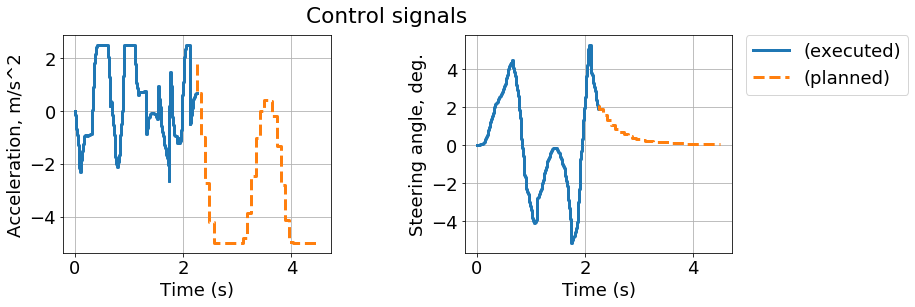

In [9]:
u_plt, u_ax1, u_ax2 = car.plot_u(u_plan, mpcprob.u_opt)

## x-y plot of car's path
Arrows show velocity. Orange components are planned but not executed.

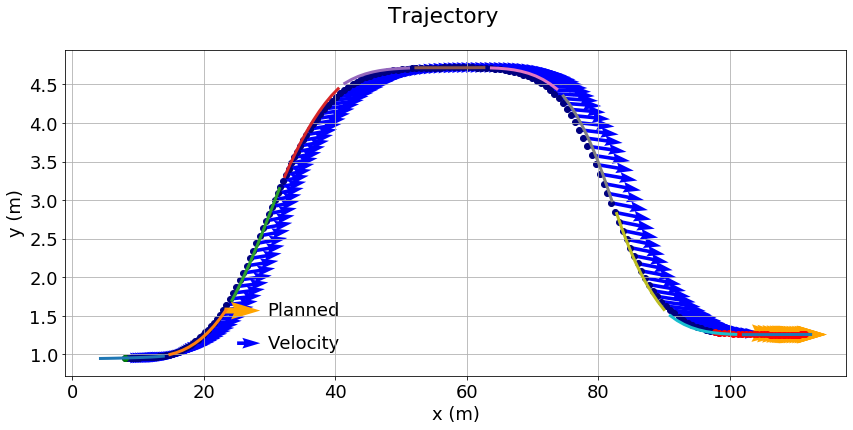

In [10]:
x_plt, x_ax = car.plot_x(x_plan, mpcprob.x_opt)
    
roadrunner.plot(ax=x_ax)
x_ax.scatter(ic[0], ic[1], color="green")

plt.show()

## x vs time and y vs time, separately, with the boundaries

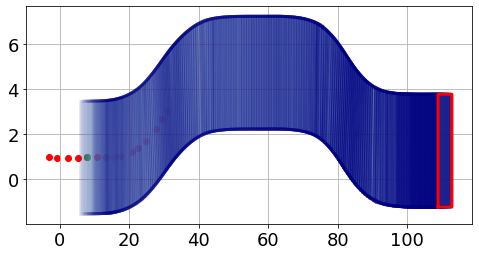

In [11]:
# Plot the road boundary as polygons
def plot_polygons(polygon_boundaries, ax=None):
    n_polys,_,_ = np.shape(polygon_boundaries)
    
    if ax is None:
        fig, ax = plt.subplots(1,1,figsize=(8,4))
        
    for k in range(n_polys):
        # Plot the polygon fill
        ax.fill(polygon_boundaries[k,:,0], polygon_boundaries[k,:,1], "lightblue", alpha=0.1+(k/(n_polys)/2))
        # Plot the line around each polygon
        ax.plot(np.concatenate([polygon_boundaries[k,:,0],polygon_boundaries[k,0:1,0]]),
                np.concatenate([polygon_boundaries[k,:,1],polygon_boundaries[k,0:1,1]]),
                color="navy", alpha=0.1+k/(n_polys)/2)

    # Plot the last polygon in RED
    ax.plot(np.concatenate([polygon_boundaries[-1,:,0],polygon_boundaries[-1,0:1,0]]),
            np.concatenate([polygon_boundaries[-1,:,1],polygon_boundaries[-1,0:1,1]]),
            color="red", alpha=1)
    return ax

ax = plot_polygons(polygon_boundaries)
ax.scatter(test_road[0:15,0], test_road[0:15,1], color='red')
ax.scatter(ic[0], ic[1], color="green")

p [[ 9.86352636 -1.54293151]
 [ 9.84307633  3.45702666]
 [13.47105718  3.47299197]
 [13.49150721 -1.52696621]]
Constraint with lower bound  -inf upper  -0.0
Constraint with lower bound  -3.0 upper  inf
Constraint with lower bound  -0.0 upper  inf
Constraint with lower bound  -inf upper  3.0
At point [[11.69627984  0.96315663]]
[ 7.69627984  8.58516873  9.47405762 10.36294651 11.25183539 12.14072428
 13.02961317 13.91850206 14.80739095 15.69627984]
ub, a, b, c, lb -0.0 -244.49638884637713 -1.0 2410.0536448787448 -inf
ub, a, b, c, lb inf 0.0044006032490275125 -1.0 3.4137111908712865 -3.0
ub, a, b, c, lb inf -244.49638884637713 -1.0 3297.0978262675135 -0.0
ub, a, b, c, lb 3.0 0.004400603249027452 -1.0 -1.5863369810491867 -inf
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      

(-10, 20)

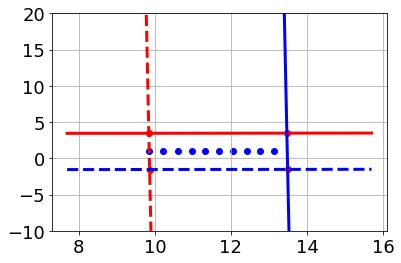

In [12]:
# Test - find a feasible point inside one polygon, to prove they work

i = 10
roadrunner.reset()
roadrunner.advance(mpcprob.model.step*np.sum(mpcprob.model.state_estimate[2,:i]))
bounds, p = bound_x(car, 0)
print("p", p)
x = casadi.MX.sym("x", 2)
lbg = []; ubg = []; g = [];

fig, ax = plt.subplots(1,1)


for (ub, a, b, c, lb) in bounds:
    print("Constraint with lower bound ", lb, "upper ", ub)
    lbg.append(np.reshape(lb,(1,)))
    ubg.append(np.reshape(ub,(1,)))
    g.append(x[0]*a + x[1]*b + c)
xy = roadrunner.evaluate()
print("At point", xy)
xl = np.linspace(xy[0,0]-4, xy[0,0]+4,10)
print(xl)
for (ub, a, b, c, lb) in bounds:
    print("ub, a, b, c, lb", ub, a, b, c, lb)
    if np.isinf(lb): # it is an upper bound
        if np.sign(a) == 1:
            ax.plot(xl, (xl*a + c)/(-b), label="upper"+str(i), color="blue", linestyle='--')
        else:
            ax.plot(xl, (xl*a + c)/(-b), label="upper"+str(i), color="red", linestyle='--')
    else:            # it is a lower bound
        if np.sign(a) == 1:
            ax.plot(xl, (xl*a + c)/(-b), label="lower"+str(i), color="red")
        else:
            ax.plot(xl, (xl*a + c)/(-b), label="lower"+str(i), color="blue")


plt.scatter(p[:,0], p[:,1], color="red")
for k in range(-5,5):
    xy = roadrunner.evaluate(mpcprob.model.step*5*k)
    plt.scatter(xy[0,0], xy[0,1], color="blue")
#for (ub, a, b, c, lb) in lowers:
#    ubg.append(np.array([np.inf,]))
#    lbg.append(np.zeros((1,)))
#    g.append(x[0]*a + x[1]*b + c)

ubg = np.concatenate(ubg)
lbg = np.concatenate(lbg)
g = casadi.vertcat(*g)

J = x[0]**2 + x[1]**2

# Create an NLP solver
prob = {'f': J, 'x': x, 'g': g}
solver = casadi.nlpsol('solver', 'ipopt', prob, {'verbose':False});

# Solve the NLP
sol = solver(x0=[2,1], lbx=-np.inf, ubx=np.inf, lbg=lbg, ubg=ubg)
print(sol['x'])
plt.ylim([-10,20])

In [13]:
print(mpcprob.model.state_estimate[2,:])

[9.38946322 9.44184712 9.36892074 9.16358211 8.84911605 8.47411605
 8.09911605 7.72411604 7.34911604 6.97411604 6.59911603 6.22411603
 5.86347929 5.57475861 5.39115197 5.31557248 5.31493961 5.34681781
 5.37461558 5.36110964 5.26221407 5.05327648 4.74419528 4.37276917
 3.99776916 3.62276916 3.24776916 2.87276915 2.49776915 2.12276915
 2.12276915]
